<center><h1>NFL Big Data Bowl 2024 Analysis</h1></center>

#### Analysis & Scripting By: Elijah Taber
#### Submission Track: Undergraduate Track
#### Email: boxcar2taber@yahoo.com

## Importing Relavent Libraries

In [1]:
# Data
import pandas as pd
import numpy as np
import glob 
import warnings
import os
import datetime
import random

warnings.filterwarnings("ignore") 

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from kerastuner.tuners import RandomSearch

## Upload & Organize Datasets

In [2]:
pd.set_option('display.max_columns', None) # ensure all columns get displayed, Pandas has an inherit limit

# Use glob and RegEx to import all files under a specific parameter, this will combine all tracking_week files into one
tracking_files = glob.glob('Datasets/tracking_week*.csv')
tracking_list = []
for week in tracking_files: # take each csv file and transform them into dataframes to append to df list
    tracking_data = pd.read_csv(week)
    tracking_list.append(tracking_data)

# Take all tracking_week dataframes and concatenate them into a single dataframe containing 9 weeks of tracking data
tracking = pd.concat(tracking_list) 

# Read in the rest of the csv files
games = pd.read_csv("Datasets/games.csv")
players = pd.read_csv("Datasets/players.csv")
plays = pd.read_csv("Datasets/plays.csv")
tackles = pd.read_csv("Datasets/tackles.csv")

In [3]:
# This dataframe tracks 1 player at a time for each play, 1 frame at a time.
tracking.head().style.format(precision=2).set_properties(**{'border': '1.5px solid blue'}).background_gradient(cmap='coolwarm')

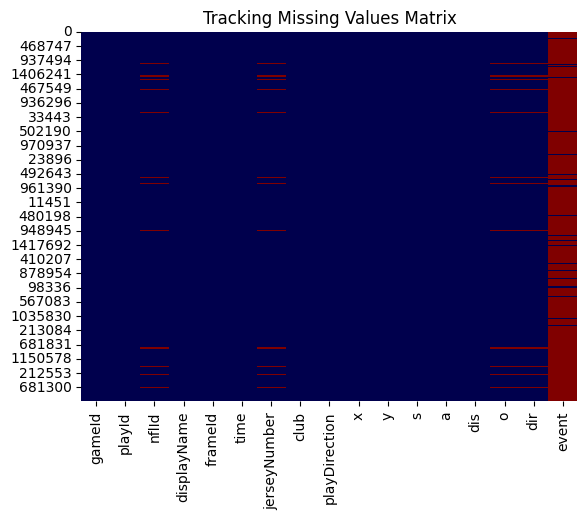

In [4]:
# Heatmap matrix of missing values in the tacking dataset
sns.heatmap(tracking.isnull(), cmap='seismic', cbar=False) # red corresponds to null values

plt.title('Tracking Missing Values Matrix')
plt.show()

In [5]:
plays.head().style.format(precision=2).set_properties(**{'border': '1.5px solid blue'}).background_gradient(cmap='coolwarm')

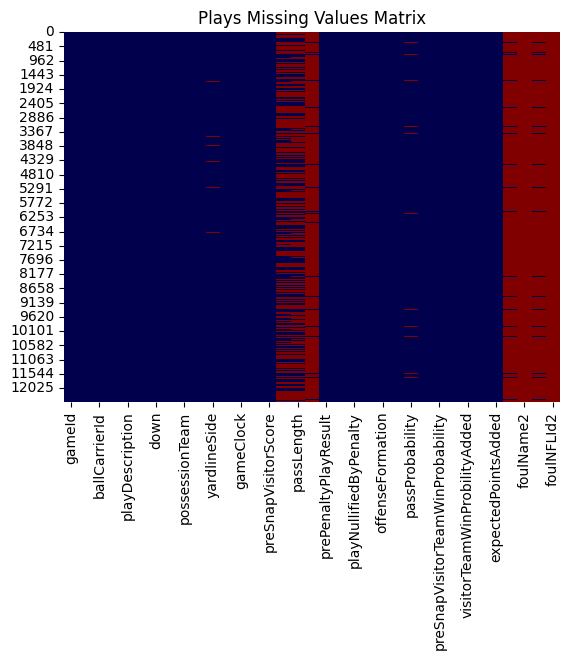

In [6]:
# Heatmap matrix of missing values in the plays dataset
sns.heatmap(plays.isnull(), cmap='seismic', cbar=False) # red corresponds to null values

plt.title('Plays Missing Values Matrix')
plt.show()

In [7]:
games.head().style.format(precision=2).set_properties(**{'border': '1.5px solid blue'}).background_gradient(cmap='coolwarm')

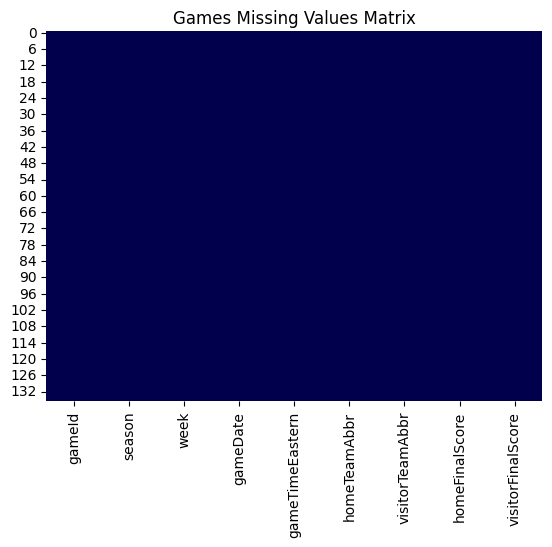

In [8]:
# Heatmap matrix of missing values in the games dataset
sns.heatmap(games.isnull(), cmap='seismic', cbar=False) # red corresponds to null values

plt.title('Games Missing Values Matrix')
plt.show()

In [9]:
players.head().style.format(precision=2).set_properties(**{'border': '1.5px solid blue'}).background_gradient(cmap='coolwarm')

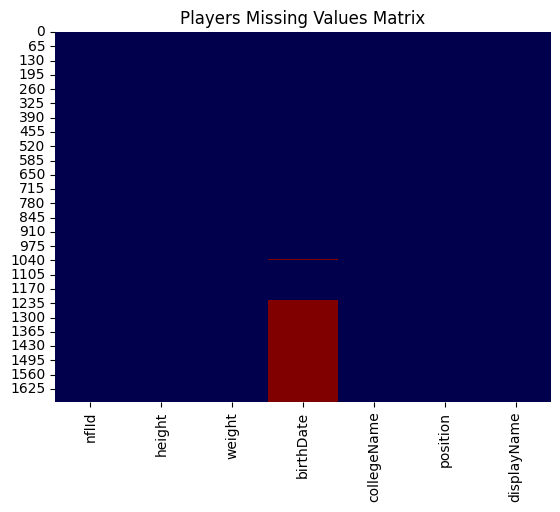

In [10]:
# Heatmap matrix of missing values in the players dataset
sns.heatmap(players.isnull(), cmap='seismic', cbar=False) # red corresponds to null values

plt.title('Players Missing Values Matrix')
plt.show()

In [11]:
tackles.head().style.format(precision=2).background_gradient(cmap='coolwarm').set_properties(**{'border': '1.5px solid black'})

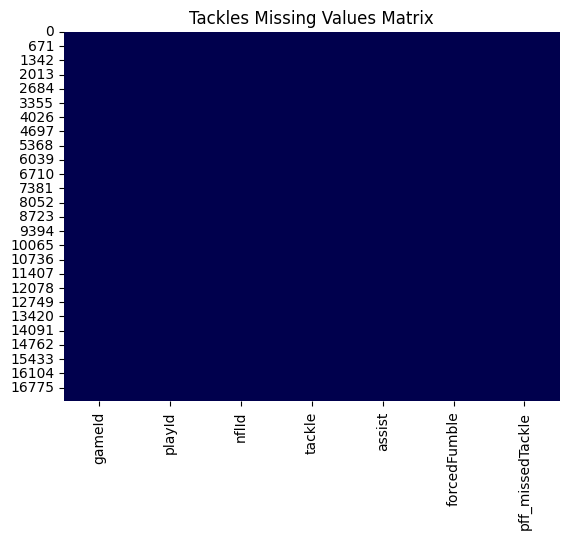

In [12]:
# Heatmap matrix of missing values in the tackles dataset
sns.heatmap(tackles.isnull(), cmap='seismic', cbar=False) # red corresponds to null values

plt.title('Tackles Missing Values Matrix')
plt.show()

## Data Wrangling

## Cleaning Tracking 

This next part is going to be a little difficult and will require some clever finessing as there is a problem with the tracking dataset and is very easy to miss. Let's try and break it down into a relatively easy to understand way. The tracking dataset, consisting of 9 different csv files (over 12 million rows), has a gameId feature that represents a unique identifier for each game, but the playId number is not unqique and reused on different games. Basically it tells us that each game has a unique ID number, and corresponding to that ID number there will be a unique playId number BUT ONLY FOR THAT SPECIFIC GAME ID. Meaning that the playId numbers are NOT unique and other games will reuse the same playId number to identify each play for that specific game. 

A good way to visualize the data phenomena is by looking at the tackles dataframe, pay attention to gameId and playId:

In [13]:
tackles_sorted = tackles.sort_values(by='playId', ascending=True)
tackles_sorted.head(10).style.set_properties(**{'border': '1.5px solid black'}).background_gradient(cmap='binary')

Notice here that there are multiple gameId's for each playId where a tackle occurred, therefore we need to make the playId feature an actual unique column in order to differentiate each tackle with a specific player (nflId). Think of turning the IDs in the above playId column into the following:

54 → 1

54 → 2

54 → 3

54 → 4

This makes things difficult when trying to group the playId's by their unique values in order to filter out a tackle without combining mutiple separate plays into one due to their ID's being the same value, which would lead to a false analysis. So we need to create an entire new feature and assign it brand new ID numbers, BUT ENSURE THAT EACH NEW ID REPRESENTS ONE UNIQUE PLAY IN CONTEXT TO EVERY GAME. We are going to need to iterate through the entire dataset and assign each game's play's a unique identifier that does not match any other game's playId. Essentially the code should cross reference the dataset before assigning a new identifier to each play. However, if we just made a new playId feature and assigned it a new number by adding 1 every time, we would assign 1 play multiple ID numbers since it is on a frame by frame basis. Therefore mapping procedures will need to be implemented to account for each frame. 

Let's use play 56 as a referance point since it is the first play in the tracking dataset and use that to confirm if the code worked, more specifically play 56 during gameId 2022090800

In [14]:
# Look at the values for index 840 and see which 
def highlight_game(s):
    is_value = s == 2022090800
    return ['background-color: green' if i else 'background-color: white' for i in is_value]

playId_56_df = tackles_sorted[tackles_sorted['playId'] == 56]
playId_56_df.head(15).style.apply(highlight_game).set_properties(**{'border': '1.5px solid green'})

To make matters more complicated, the same playId for each game is shared across each player involved in that play and does not specify which player is responsible for the tackle, it just uses the same event identifier for each frame for each player. This means that we will need to cross referance the tracking dataset with the tackles dataframe in order to identify who is responsible for the tackle and then assign one tackle value to an nflId for each play (or more is there is more than one responsible). We should intentionally keep the tackle value in the event column so that we know which frame the tackle occurs for aggregation operations.

In [15]:
# Let's cross-reference the tracking and tackles datasets Filter out rows from tackles_df where a tackle did not occur
tackles_df = tackles[tackles['tackle'] == 1]

# Merge the tracking dataframe with the tackles dataframe to align the tackles with the corresponding frames in 
# the tracking data
tracking_merged = pd.merge(tracking, tackles_df, on=['gameId', 'playId', 'nflId'], how='left')

# Identify the frames with tackles and update the 'event' column
tracking_merged.loc[tracking_merged['tackle'] == 1, 'event'] = 'TACKLER'

# Drop the columns from tackles_df that are no longer needed
tracking_merged.drop(['tackle', 'assist', 'forcedFumble', 'pff_missedTackle'], axis=1, inplace=True)

#Assign unique identifiers for each play
unique_plays = tracking_merged[['gameId', 'playId']].drop_duplicates()
unique_plays['updated_playId'] = range(len(unique_plays))

# Merge back to get the unique_playId for each row in the tracking dataframe
tracking_updated = tracking_merged.merge(unique_plays, on=['gameId', 'playId'], how='left')

Boom, after many trial and errors, this code perfomed beautifully in conducting a cross reference operation with the tracking and tackles dataframes in order to first find out which nflId is responsible for the tackles for a specific play in a specific game within the tackles dataframe, then assign that nflId within our tracking dataframe, an identifier of 'TACKLER' to properly identify who is responsible for a tackle for a specific play in a specific game. If we look at the tackles dataframe (the reference one created for playId 56 earlier), we can see that the nflId lines up, meaning the script has correctly identified who is responsible for the tackle for each play! Now that there is a TACKLER identifier in the event column, we can aggregate it later and filter each play to determine the statistics for each player performing a tackle.

This code also assigns a completely new playId for each play in order to actually give each play a unique identifier that does not correspond to any other gameId. Essentially this code is creating a type of mapping sequence between each unique combination of (gameId, playId) and a corresponding unique playId. This ensures that within each game, the 'updated_playId' is consistent for all frames of a specific play, but maintains it's uniqueness across all plays in all games.

In [16]:
# Looks like the code worked as expected, inspect the second to last column and see how the actual tackler displays TACKLE 
# in the event column and how that same nflId lines up with the value in the tackles dataframe
def highlight_TACKLER(x):
    is_value = x == 'TACKLER'
    return ['background-color: blue' if i else 'background-color: white' for i in is_value]

# Scroll to index 150
tracking_updated.head().style.apply(highlight_TACKLER).set_properties(**{'border': '1.5px solid black'})

Now let's look at the last column and see how the new playId is assigned.

In [17]:
# Check the last column and how it correctly displays a new unique identifier for each play while maintaining 
# consistency for each frame , scroll over to unique_playId if need be
def highlight_play_difference(x):
    is_value = x == 1
    return ['background-color: green' if i else 'background-color: white' for i in is_value]

tracking_updated.head().style.apply(highlight_play_difference).set_properties(**{'border': '1.5px solid black'})

#### Filter tracking

In [18]:
# Step 1: Identify the frame where the tackle event ('tackle') occurs in each play
tackle_frames = tracking_updated[tracking_updated['event'] == 'tackle'].groupby('playId')['frameId'].first()

# Step 2: Merge this information back into the original DataFrame
tracking_updated = tracking_updated.merge(tackle_frames.rename('tackleFrame'), on='playId', how='left')

# Step 3: Assign 1 to the 'tackle' column at the specific frame where the tackle occurred for the responsible 'nflId'
# and 0 for all other frames
tracking_updated['tackle'] = ((tracking_updated['event'] == 'TACKLER') & (tracking_updated['frameId'] == tracking_updated['tackleFrame'])).astype(int)

# Dropping the auxiliary 'tackleFrame' column as it's no longer needed
tracking_updated.drop('tackleFrame', axis=1, inplace=True)

tracking_updated.head().style.format(precision=2).background_gradient(cmap='plasma').set_properties(**{'border': '1.5px solid red'})

In [19]:
# Filter out redundant features and assign relavent features to the tracking dataframe
tracking_updated = tracking_updated[['gameId', 'playId','updated_playId', 'frameId', 'nflId', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'tackle']]

#### Rename Columns For Enhanced Clarity

In [20]:
# Rename a few features to provide clarity on each feature
tracking_updated.rename(columns = {
    'club': 'team', 
    's': 'speed', 
    'a': 'acceleration',
    'dis': 'distance',
    'o': 'orientation',
    'dir': 'direction'
}, inplace = True)

## Main Dataframe

Now we have a nice, clean dataset, with unique identifiers for each play in order to prevent overlap (which would lead to a false analysis), all that is left to do is handle missing values. The below dataset is the most important dataset for the goal of this project (hence why it is named "main_df" now), which is to predict whether a tackle will occur or not. This dataframe will be the main focus of feature engineering and model creation. For now, we should condense this gigantic dataset down to a dataframe that is more manageable for Exploratory Data Analysis in order the better understand the nature of each feature. Then, once we have a strong foundation and understanding of all the features in every dataset, we will add/drop features to this dataframe and prep it for machine learning model classifiers.

In [21]:
main_df = tracking_updated
main_df.head().style.format(precision=2).background_gradient(cmap='plasma').set_properties(**{'border': '1.5px solid red'})

#### Numerical Encoding

In [22]:
# Change to 0 for left and 1 for right
main_df['playDirection'] = main_df['playDirection'].map({'left': 0, 'right': 1})
main_df.head().style.format(precision=2).background_gradient(cmap='plasma').set_properties(**{'border': '1.5px solid red'})

#### Group, Extract, & Aggregate Tackle Statistics
As a reminder, in football, a play ends when the ball carrier is tackled, goes out of bounds, scores a touchdown, or the referee blows their whistle to stop the play.

First, let's filter out the tackles from the tracking_updated dataframe in order to know which frames the tackle occurred. Then we are going to perform the first aggregation function by gettting the average speed of the tackler during the play where the tackle occurred.

In [23]:
# Group by gameId, updated_playId, and nflId, then aggregate the speed across all 'TACKLER' frames
speed_agg = tracking_updated[tracking_updated['event'] == 'TACKLER'].groupby(
    ['gameId', 'updated_playId', 'nflId'])['speed'].mean().reset_index(name='avg_speed')

Now let's calculate the total distance for each player performing the tackle in each play

In [24]:
# Calculate the total distance for each play
distance_agg = tracking_updated[tracking_updated['event'] == 'TACKLER'].groupby(
    ['gameId', 'updated_playId', 'nflId'])['distance'].sum().reset_index(name='total_distance')

The next aggregate function function is designed to get the net difference between the first and last position for each play. This can be indicative of their positioning and effort in making the tackle. We'll first identify the intitial position for both x and y, then we'll calculate the displacement for each x and y coordinate from the start of the play to the end of the play. 

In [25]:
# Calculate the initial position at the start of the play
initial_positions = tracking_updated.groupby(['gameId', 'updated_playId', 'nflId']).agg(
    initial_x=('x', 'first'),
    initial_y=('y', 'first')
).reset_index()

# Calculate the position at the tackle frame
tackle_positions = tracking_updated[tracking_updated['tackle'] == 1][['gameId', 'updated_playId', 'nflId', 'x', 'y']]
tackle_positions = tackle_positions.rename(columns={'x': 'tackle_x', 'y': 'tackle_y'})

# Merge the initial and tackle positions
displacement_agg = initial_positions.merge(tackle_positions, on=['gameId', 'updated_playId', 'nflId'], how='left')

# Calculate the displacement from the frame of tackle and the start frame
displacement_agg['x_displacement'] = (
    displacement_agg['tackle_x'] - displacement_agg['initial_x']).abs()
displacement_agg['y_displacement'] = (
    displacement_agg['tackle_y'] - displacement_agg['initial_y']).abs()

# Drop the intermediate columns
displacement_agg = displacement_agg.drop(columns=['initial_x', 'initial_y', 'tackle_x', 'tackle_y'])

Let's consolidate the calculations into a fresh dataframe

In [26]:
# Merge all the aggregated data in an order we want
tracking_tackles = speed_agg.merge(
    distance_agg, on=['gameId', 'updated_playId', 'nflId'])

tracking_tackles = tracking_tackles.merge(
    displacement_agg, on=['gameId', 'updated_playId', 'nflId'], how='left')

Now that we have the exact frame for when the tackle occurred, let's simply merge the acceleration, direction, and orientation with the fresh dataframe in order to find each tackler's acceleration, direction, and orientation at the time of the tackle.

In [27]:
# Separate DataFrame for calculations at the tackle frame
tackle_data = tracking_updated[tracking_updated['tackle'] == 1]

tracking_tackles = tracking_tackles.merge(
    tackle_data[['gameId', 'updated_playId', 'nflId', 'acceleration', 'direction', 'orientation']], 
    on=['gameId', 'updated_playId', 'nflId'], how='left')

In [28]:
# Let's verify the shape and take a look at the dataframe to make sure all aggregation function performed correctly 
print(tracking_tackles.shape)
tracking_tackles.head().style.background_gradient(cmap='cool').set_properties(**{'border': '1.5px solid blue'})

(9919, 10)


This tackles dataframe now contains specific tracking statistics for every single player who performed a tackle throughout the entire 9 week tracking dataset. This dataframe is now cleaned, organized, and ready for further analysis.

#### Check For Proper Data Types

In [29]:
# The data types are looking solid, however the nflId should be changed to an integer for uniformity
tracking_tackles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9919 entries, 0 to 9918
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          9919 non-null   int64  
 1   updated_playId  9919 non-null   int64  
 2   nflId           9919 non-null   float64
 3   avg_speed       9919 non-null   float64
 4   total_distance  9919 non-null   float64
 5   x_displacement  6632 non-null   float64
 6   y_displacement  6632 non-null   float64
 7   acceleration    6632 non-null   float64
 8   direction       6632 non-null   float64
 9   orientation     6632 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 775.1 KB


Let's change the nflId to an integer since it is an Id value and should not be a float.

In [30]:
tracking_tackles['nflId'] = tracking_tackles['nflId'].astype('int64')
tracking_tackles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9919 entries, 0 to 9918
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          9919 non-null   int64  
 1   updated_playId  9919 non-null   int64  
 2   nflId           9919 non-null   int64  
 3   avg_speed       9919 non-null   float64
 4   total_distance  9919 non-null   float64
 5   x_displacement  6632 non-null   float64
 6   y_displacement  6632 non-null   float64
 7   acceleration    6632 non-null   float64
 8   direction       6632 non-null   float64
 9   orientation     6632 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 775.1 KB


## Cleaning Plays

#### Filter Plays
Let's first filter for features that would be useful for tackle analysis later.

In [31]:
plays_updated = plays[['gameId', 'playId', 'ballCarrierId', 'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'defensiveTeam','passResult', 'offenseFormation','defendersInTheBox']]
plays_updated.head().style.set_properties(**{'border': '1.5px solid blue'}).background_gradient(cmap='Blues')

#### Numerical Encoding
Let's change some of the categorical feautures that will be useful for model building into numerical values.

In [32]:
plays_updated.passResult.unique()

array(['C', nan, 'R'], dtype=object)

This is intereseting, this does not comply with the documentation in the data dictionary:

**passResult: Dropback outcome of the play (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble, text)**

We will still keep it for possible further analysis.

In [33]:
plays_updated.offenseFormation.unique()

array(['SHOTGUN', 'I_FORM', 'SINGLEBACK', 'EMPTY', 'PISTOL', 'WILDCAT',
       'JUMBO', nan], dtype=object)

In [34]:
plays_updated['defendersInTheBox'].unique()

array([ 7.,  6.,  5.,  4.,  9.,  8.,  3., 10., 11.,  2., nan,  1.])

In [35]:
# First, map the non-NaN values
pass_result_mapping = {'C': 1, 'R': 2}
plays_updated['passResult'] = plays_updated['passResult'].map(pass_result_mapping)

# Then, fill NaN values with 0
plays_updated['passResult'].fillna(0, inplace=True)

plays_updated['defendersInTheBox'].fillna(0, inplace=True)

# Map the unique names to unique numbers
formation_mapping = {
    'SHOTGUN': 0,
    'I_FORM': 1,
    'SINGLEBACK': 2,
    'EMPTY': 3,
    'PISTOL': 4,
    'WILDCAT': 5,
    'JUMBO': 6
}

# Find the mode of the 'offenseFormation' column (excluding NaN)
mode_value = plays_updated['offenseFormation'].mode(dropna=True)[0]

# Replace NaN with the mode
plays_updated['offenseFormation'].fillna(mode_value, inplace=True)

# Map the formations to numerical values using your provided mapping
plays_updated['offenseFormationNumeric'] = plays_updated['offenseFormation'].map(formation_mapping)
plays_updated[['passResult','offenseFormationNumeric']].head(15).style.set_properties(**{'border': '1.5px solid blue'}).background_gradient(cmap='Blues')

passResult
* C: 1
* R: 2
* NaN': 0

offenseFormation
* SHOTGUN: 0
* I_FORM: 1
* SINGLEBACK: 2
* EMPTY: 3
* PISTOL: 4
* WILDCAT: 5
* JUMBO: 6

#### Check For Proper Data Types

In [36]:
plays_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   12486 non-null  int64  
 1   playId                   12486 non-null  int64  
 2   ballCarrierId            12486 non-null  int64  
 3   playDescription          12486 non-null  object 
 4   quarter                  12486 non-null  int64  
 5   down                     12486 non-null  int64  
 6   yardsToGo                12486 non-null  int64  
 7   possessionTeam           12486 non-null  object 
 8   defensiveTeam            12486 non-null  object 
 9   passResult               12486 non-null  float64
 10  offenseFormation         12486 non-null  object 
 11  defendersInTheBox        12486 non-null  float64
 12  offenseFormationNumeric  12486 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.2+ MB


In [37]:
plays_updated['passResult'] = plays_updated['passResult'].astype('int64')
plays_updated['defendersInTheBox'] = plays_updated['defendersInTheBox'].astype('int64')
plays_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   gameId                   12486 non-null  int64 
 1   playId                   12486 non-null  int64 
 2   ballCarrierId            12486 non-null  int64 
 3   playDescription          12486 non-null  object
 4   quarter                  12486 non-null  int64 
 5   down                     12486 non-null  int64 
 6   yardsToGo                12486 non-null  int64 
 7   possessionTeam           12486 non-null  object
 8   defensiveTeam            12486 non-null  object
 9   passResult               12486 non-null  int64 
 10  offenseFormation         12486 non-null  object
 11  defendersInTheBox        12486 non-null  int64 
 12  offenseFormationNumeric  12486 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.2+ MB


## Cleaning Games

#### Filter Games

In [38]:
games_updated = games[['gameId', 'week', 'gameDate', 'homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore']]

In [39]:
games_updated.head().style.set_properties(**{'border': '1.5px solid red'}).background_gradient(cmap='Reds')

#### Check For Proper Data Types

In [40]:
games_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gameId             136 non-null    int64 
 1   week               136 non-null    int64 
 2   gameDate           136 non-null    object
 3   homeTeamAbbr       136 non-null    object
 4   visitorTeamAbbr    136 non-null    object
 5   homeFinalScore     136 non-null    int64 
 6   visitorFinalScore  136 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 7.6+ KB


Data types look solid.

## Cleaning Players

#### Filter Players

In [41]:
players_updated = players[['nflId', 'height', 'weight', 'position', 'displayName']]

In [42]:
players_updated.head().style.set_properties(**{'border': '1.5px solid green'}).background_gradient(cmap='Greens')

In [43]:
# Let's split the object into 2 numerical values and add them together to get total inches
def height_to_inches(height):
    feet, inches = map(int, height.split('-'))
    return feet * 12 + inches

# Convert height of each player to total inches
players_updated['height_inches'] = players_updated['height'].apply(height_to_inches)

# Encode the position column into numerical values
unique_positions = players_updated['position'].unique()
position_to_numeric = {position: index for index, position in enumerate(unique_positions)}
players_updated['position_numeric'] = players_updated['position'].map(position_to_numeric)

In [44]:
players_updated.head(10).style.set_properties(**{'border': '1.5px solid green'}).background_gradient(cmap='Greens')

In [45]:
players_updated.position_numeric.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18], dtype=int64)

#### Position's Key
0: QB

1: T

2: TE

3: WR

4: DE

5: NT

6: SS

7: FS

8: G

9: OLB

10: DT

11: CB

12: RB

13: C

14: ILB

15: MLB

16: FB

17: LS

18: DB

#### Position Abbreviations
C – Center

CB – Corner Back

DB – Defensive Back

DE – Defensive End

DL – Defensive Lineman

DT – Defensive Tackle

FB – Full Back

FS – Free Safety

HB – Half Back

ILB – Inside Line Backer

K – Kicker

LT – Left Tackle

LB- Line Backer

MLB – Middle Line Backer

NT – Nose Tackle

OL – Offensive Lineman

OLB – Outside Line Backer

P – Punter

PR – Punt Returner

QB – Quarter Back

RB – Running Back

RT – Right Tackle

S – Safety

SS – Strong Safety

T – Tackle

TE – Tight End

WR – Wide Receiver

LS - Long Snapper

#### Check For Proper Data Types

In [46]:
players_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   nflId             1683 non-null   int64 
 1   height            1683 non-null   object
 2   weight            1683 non-null   int64 
 3   position          1683 non-null   object
 4   displayName       1683 non-null   object
 5   height_inches     1683 non-null   int64 
 6   position_numeric  1683 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 92.2+ KB


Data types look solid.

## Cleaning Tackles

#### Filter Tackles

We are going to keep all features in this dataframe.

In [47]:
tackles.head().style.set_properties(**{'border': '1.5px solid orange'}).background_gradient(cmap='Oranges')

In [48]:
tackles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17426 entries, 0 to 17425
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   gameId            17426 non-null  int64
 1   playId            17426 non-null  int64
 2   nflId             17426 non-null  int64
 3   tackle            17426 non-null  int64
 4   assist            17426 non-null  int64
 5   forcedFumble      17426 non-null  int64
 6   pff_missedTackle  17426 non-null  int64
dtypes: int64(7)
memory usage: 953.1 KB


Data types look solid.

## Manipulating Missing Data
Let's handle the missing values before moving onto some EDA operations. We'll address the dataframes from the heatmaps we created at the beginning.

#### Main Dataframe

In [49]:
# Check the total missing values for each feature
print(main_df.shape)
main_df.isnull().sum()

(12187398, 16)


gameId                   0
playId                   0
updated_playId           0
frameId                  0
nflId               530060
team                     0
playDirection            0
x                        0
y                        0
speed                    0
acceleration             0
distance                 0
orientation         528887
direction           528887
event             10715219
tackle                   0
dtype: int64

In [50]:
# These packages need to be imported in order
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# Replace null values in 'event' with 0
main_df['event'] = main_df['event'].fillna(0)

# Drop null values in the nflId column as this is a categorical value and there are too many missing rows
main_df.dropna(subset=['nflId'], inplace=True)

# Use IterativeImputer for 'orientation' and 'direction'
iterative_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=10)
main_df[['orientation', 'direction']] = iterative_imputer.fit_transform(main_df[['orientation', 'direction']])

In [51]:
main_df.shape
main_df.isnull().sum()

gameId            0
playId            0
updated_playId    0
frameId           0
nflId             0
team              0
playDirection     0
x                 0
y                 0
speed             0
acceleration      0
distance          0
orientation       0
direction         0
event             0
tackle            0
dtype: int64

#### Tracking Tackles Dataframe

In [52]:
# Check the total missing values for each feature
print(tracking_tackles.shape)
tracking_tackles.isnull().sum()

(9919, 10)


gameId               0
updated_playId       0
nflId                0
avg_speed            0
total_distance       0
x_displacement    3287
y_displacement    3287
acceleration      3287
direction         3287
orientation       3287
dtype: int64

This amount of missing values is not surprising, looking back at the heatmap of the original tracking dataset, there are a lot of missing values. Now that we have an updated and organized dataframe, we can begin filling the missing values with the most probable values. Chances are that there are lot of players that have at least 2 tackles over a 9 week period. 

So what we need to do is create a function that compares rows that have null values with it's respective nflId row (or rows) and use those values to fill in the missing values of the null rows. This way we are not filling the missing values with a global averge, which would be very much a bad idea as different player positions require more movement than others, i.e. a defensive tackle will have a lot less overall movement than a cornerback. 

In [53]:
# Defines a custom imputation function to fill missing values based on the same nflId's non-missing values
def impute_with_nflid(df, column):
    # Group by nflId and fill missing values with the mean of each group
    return df.groupby('nflId')[column].transform(lambda x: x.fillna(x.mean()))

# Apply the custom imputation function to the relevant columns through itteration of null columns
for column in ['x_displacement', 'y_displacement', 'acceleration', 'direction', 'orientation']:
    tracking_tackles[column] = impute_with_nflid(tracking_tackles, column)

# After imputation, let's check if there are any missing values left
missing_values_after_imputation = tracking_tackles.isnull().sum()
print(missing_values_after_imputation)

gameId             0
updated_playId     0
nflId              0
avg_speed          0
total_distance     0
x_displacement    37
y_displacement    37
acceleration      37
direction         37
orientation       37
dtype: int64


There are 37 players from the null set that have only 1 tackle in the 9 week period. These values will be dropped for analysis.

In [54]:
tracking_tackles.dropna(inplace=True)

Let's recheck the shape and see if they dropped correctly.

In [55]:
print(tracking_tackles.shape)
tracking_tackles.isnull().sum()

(9882, 10)


gameId            0
updated_playId    0
nflId             0
avg_speed         0
total_distance    0
x_displacement    0
y_displacement    0
acceleration      0
direction         0
orientation       0
dtype: int64

#### Plays Dataframe

In [56]:
print(plays_updated.shape)
plays_updated.isnull().sum()

(12486, 13)


gameId                     0
playId                     0
ballCarrierId              0
playDescription            0
quarter                    0
down                       0
yardsToGo                  0
possessionTeam             0
defensiveTeam              0
passResult                 0
offenseFormation           0
defendersInTheBox          0
offenseFormationNumeric    0
dtype: int64

#### Game Dataframe

In [57]:
print(games_updated.shape)
games_updated.isnull().sum()

(136, 7)


gameId               0
week                 0
gameDate             0
homeTeamAbbr         0
visitorTeamAbbr      0
homeFinalScore       0
visitorFinalScore    0
dtype: int64

#### Players Dataframe

In [58]:
print(players_updated.shape)
players_updated.isnull().sum()

(1683, 7)


nflId               0
height              0
weight              0
position            0
displayName         0
height_inches       0
position_numeric    0
dtype: int64

#### Tackles Dataframe

In [59]:
print(tackles.shape)
tackles.isnull().sum()

(17426, 7)


gameId              0
playId              0
nflId               0
tackle              0
assist              0
forcedFumble        0
pff_missedTackle    0
dtype: int64

## Check for duplicates

In [60]:
def duplicates(df):
    before = df.shape[0]
    df = df.drop_duplicates()
    after = df.shape[0]

    total_duplicates = before - after
    return f"There are a total of {total_duplicates} duplicates in the"

In [61]:
print(duplicates(tracking_tackles), "tracking_tackles dataframe")
print(duplicates(plays_updated), "plays_updated dataframe")
print(duplicates(games_updated), "games_updated dataframe")
print(duplicates(players_updated), "players_updated dataframe")
print(duplicates(tackles), "tackles dataframe")

There are a total of 0 duplicates in the tracking_tackles dataframe
There are a total of 0 duplicates in the plays_updated dataframe
There are a total of 0 duplicates in the games_updated dataframe
There are a total of 0 duplicates in the players_updated dataframe
There are a total of 0 duplicates in the tackles dataframe


## Exploratory Data Analysis
Understanding the nature of the features in this dataset. This is where the heart of the analysis resides.

## Main Dataframe

In [62]:
main_df.describe().style.set_properties(**{'border': '1.5px solid red'}).background_gradient(cmap='plasma')

#### Correlation Matrix

Let's check for multicollinearity with a grid clustermap, by creating an array that shows the correlation of each column with one another. These values range from -1 to 1 which represent the R^2 values, this is esepecially usful for large datasets that have hidden correlations. This map is designed to cluster the higher correlated values together in order to spot patterns. Ignore the 1.0 values as they represent features that correlate with themselves. 

<Figure size 800x600 with 0 Axes>

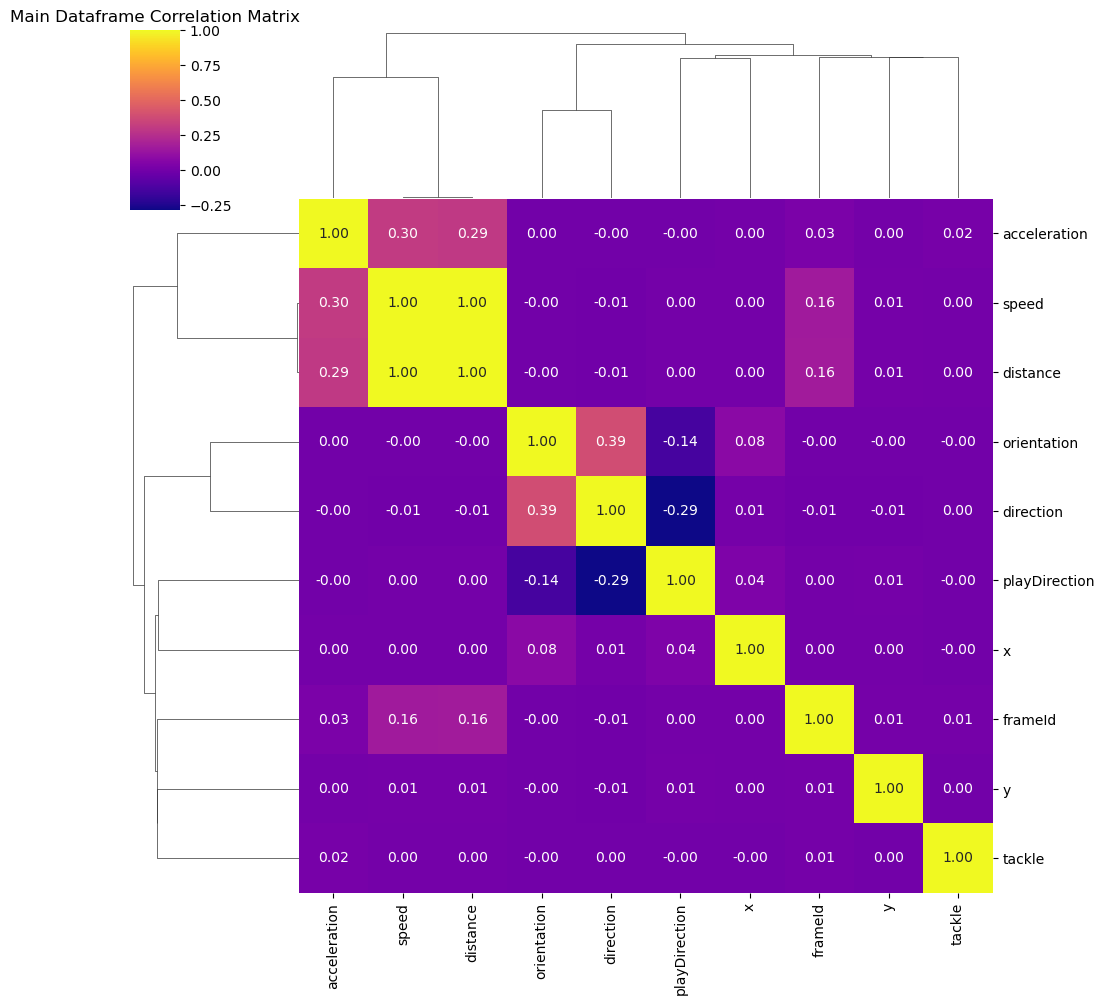

In [ ]:
plt.figure(figsize=(8, 6))

columns_to_plot = [col for col in main_df.columns if col not in ['gameId', 'updated_playId', 'playId', 'nflId', 'team', 'event']]

corr_grid = main_df[columns_to_plot].corr()
sns.clustermap(
    corr_grid,
    cmap='plasma',
    xticklabels=corr_grid.columns,
    yticklabels=corr_grid.columns,
    annot=True, 
    fmt=".2f"
)

plt.title('Main Dataframe Correlation Matrix')
plt.show()

## Tracking Tackles Dataframe

In [ ]:
tracking_tackles.describe().style.set_properties(**{'border': '1.5px solid black'}).background_gradient(cmap='binary')

#### Correlation Matrix

<Figure size 800x600 with 0 Axes>

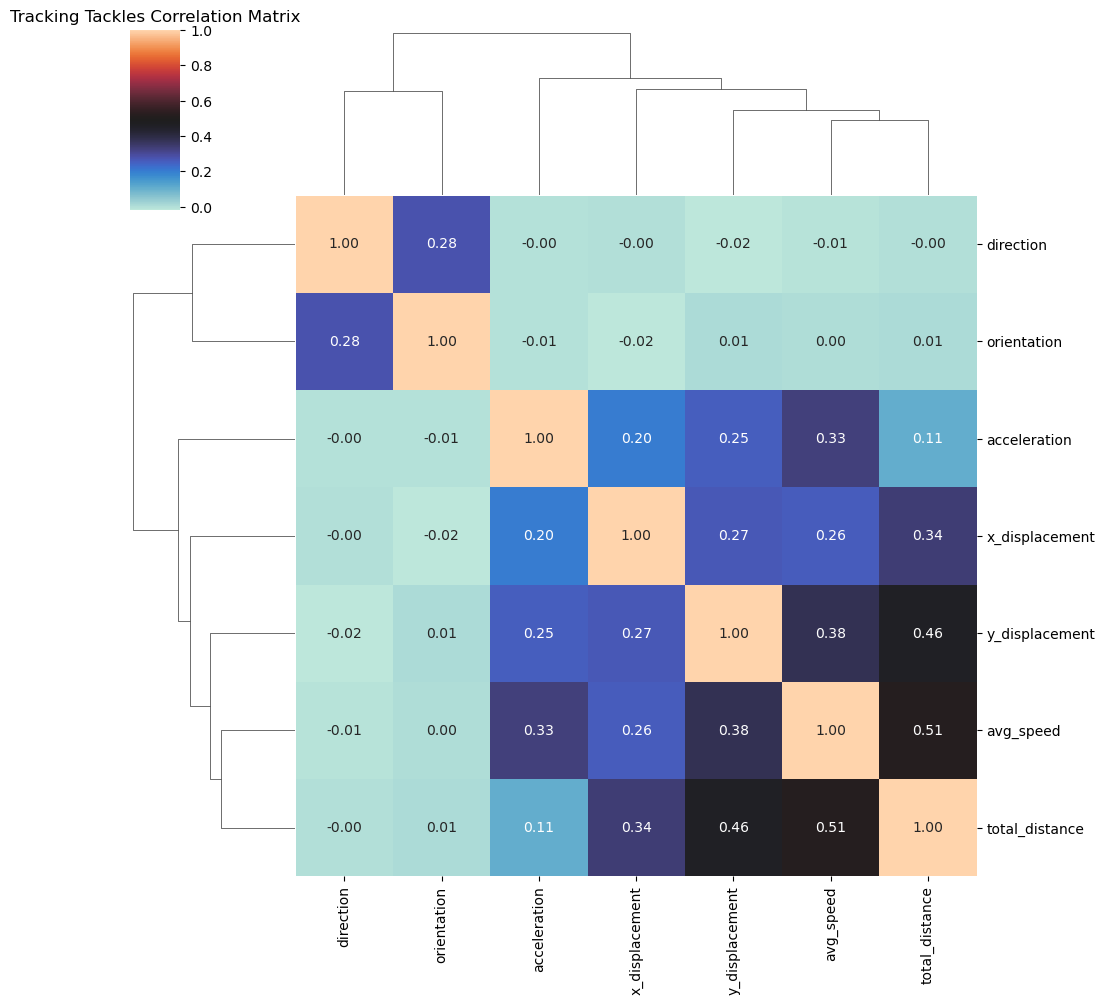

In [ ]:
plt.figure(figsize=(8, 6))

# Select columns except 'gameId' and 'playId'.
columns_to_plot = [col for col in tracking_tackles.columns if col not in ['gameId', 'updated_playId', 'playId', 'nflId']]

corr_grid = tracking_tackles[columns_to_plot].corr()
sns.clustermap(
    corr_grid,
    cmap='icefire',
    xticklabels=corr_grid.columns,
    yticklabels=corr_grid.columns,
    annot=True, 
    fmt=".2f"
)

plt.title('Tracking Tackles Correlation Matrix')
plt.show()

It appears that these features have low to moderate correlations with each other.

#### Correlation Pairplot
Let's visualize these values to get a better idea of how these features correlate with each other.

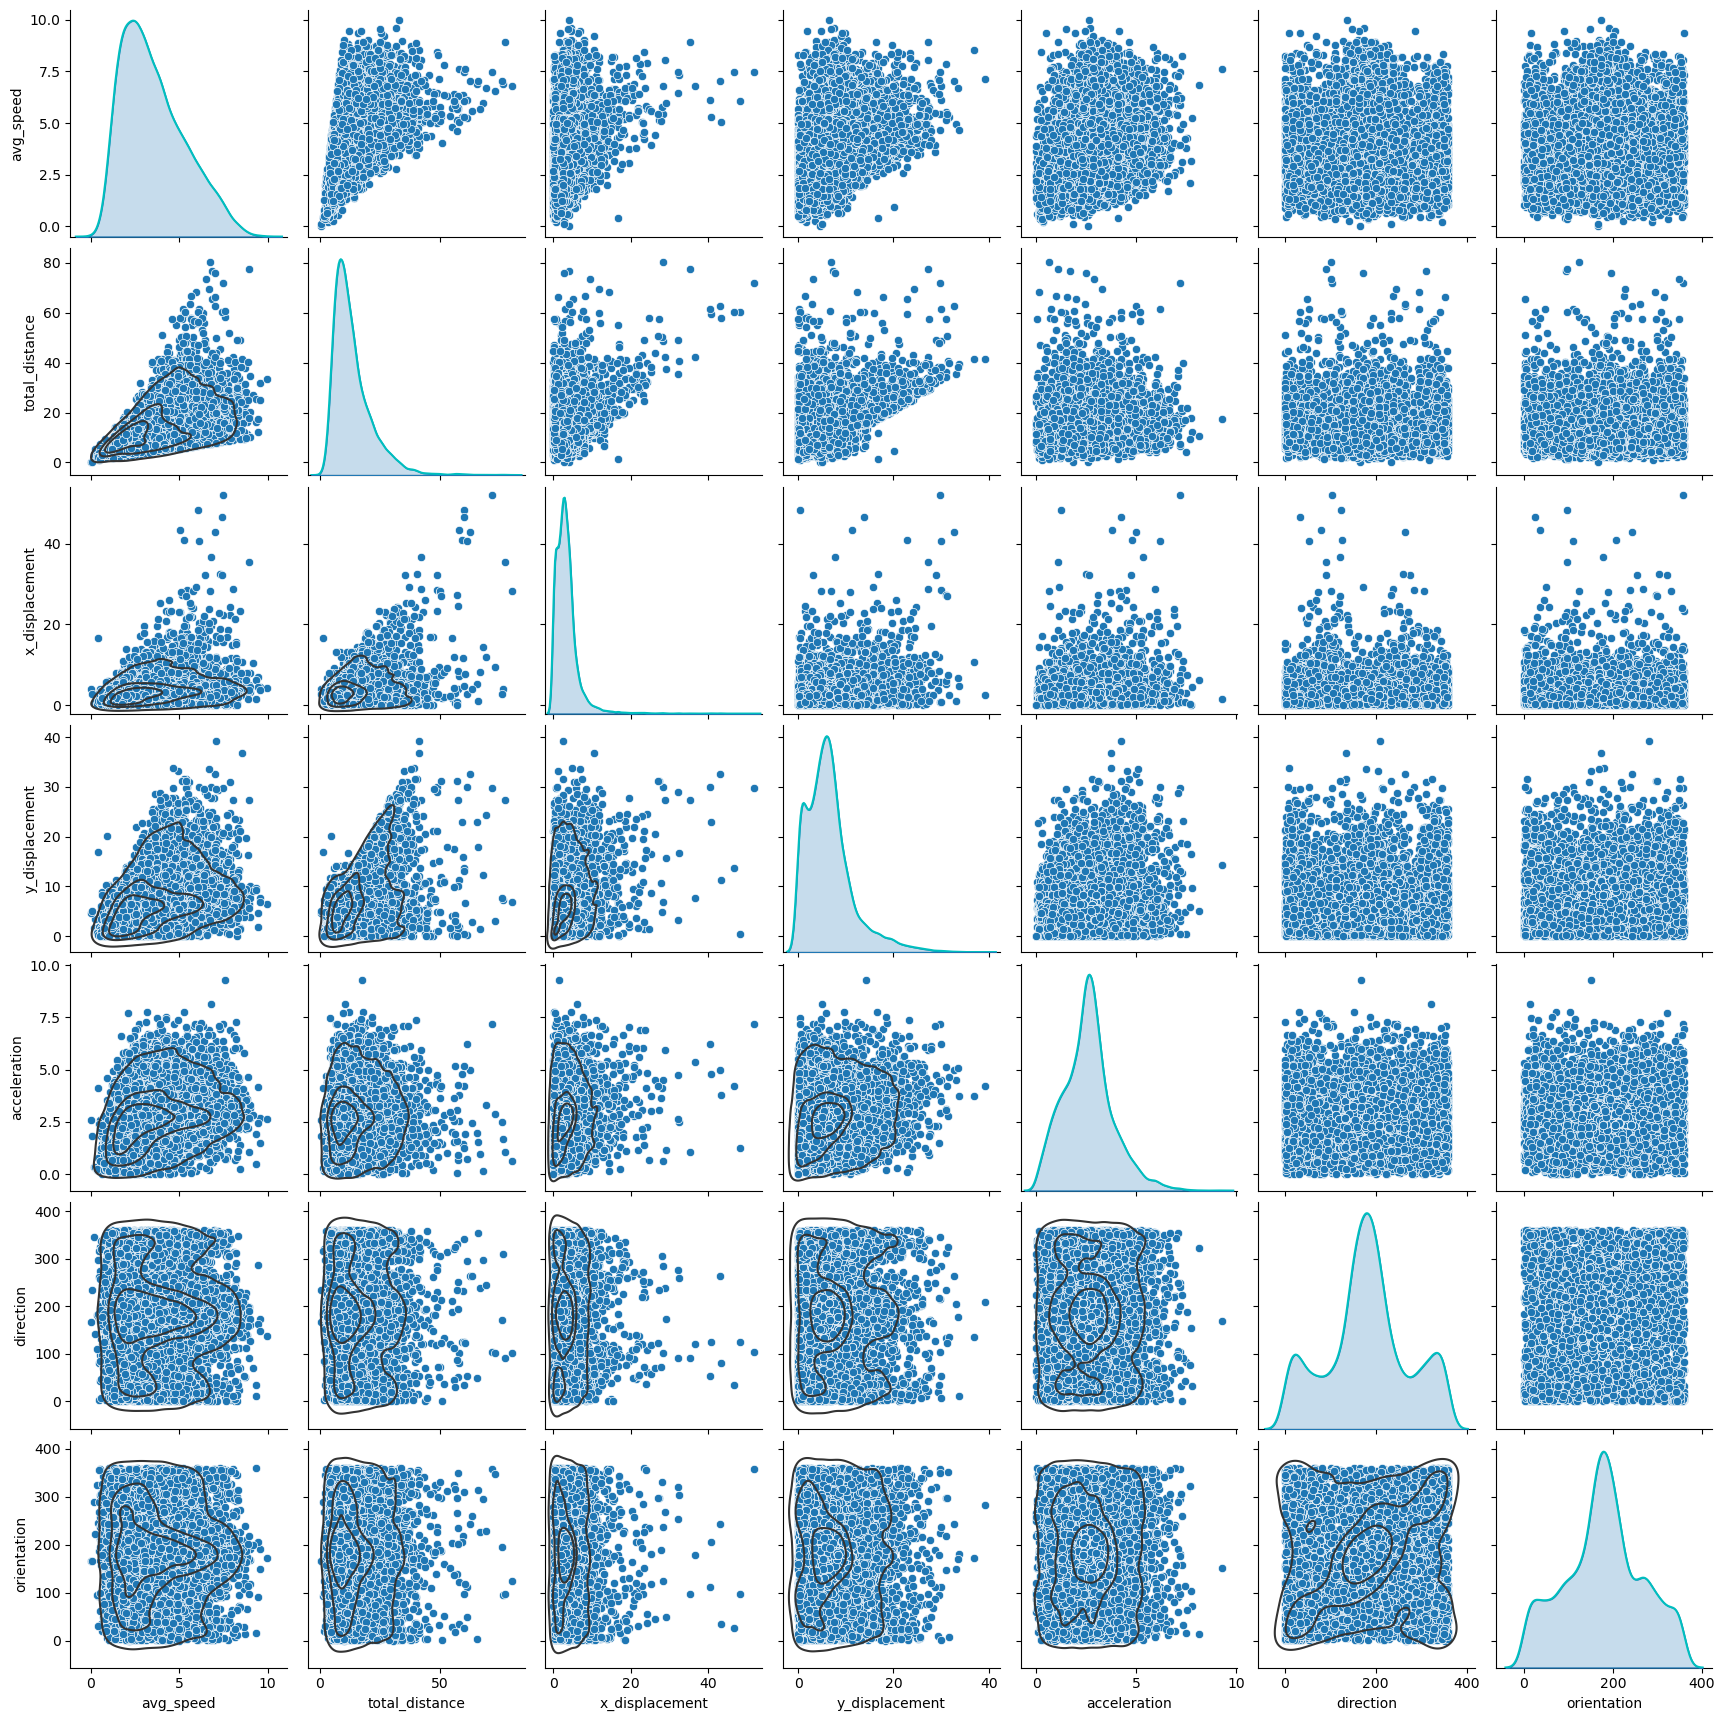

In [ ]:
pairplot = sns.pairplot(tracking_tackles[columns_to_plot], diag_kind="kde")
pairplot.map_lower(sns.kdeplot, levels=4, color=".2")
pairplot.map_diag(sns.kdeplot, color='c')

plt.rcParams.update({'font.size': 15})

plt.show()

#### Interpretation
Not surprisingly, the total distance a tackler covers is largely correlated with how much vertical distance they cover (x_displacement).

#### Average Speed

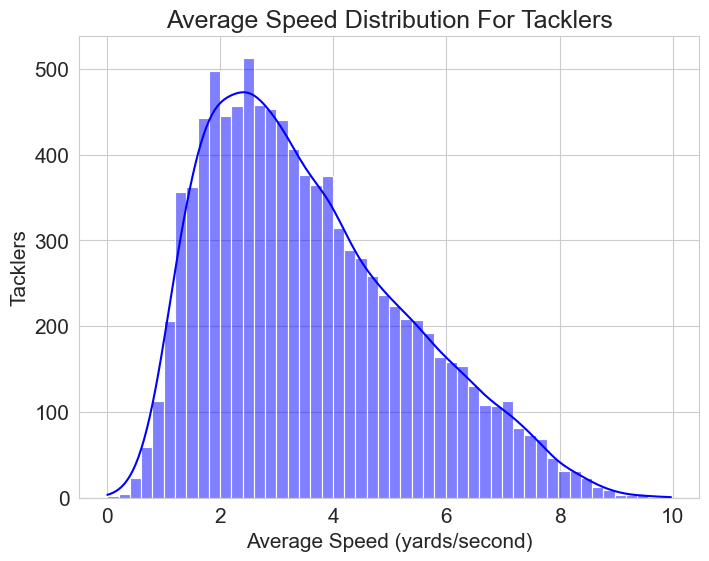

In [ ]:
# Histogram of avg_speed
sns.set_style('whitegrid')

plt.figure(figsize=(8, 6))
sns.histplot(data=tracking_tackles, x='avg_speed', bins=50, kde=True, color='blue')
plt.title('Average Speed Distribution For Tacklers')
plt.xlabel('Average Speed (yards/second)')
plt.ylabel('Tacklers')
plt.show()

<Figure size 800x600 with 0 Axes>

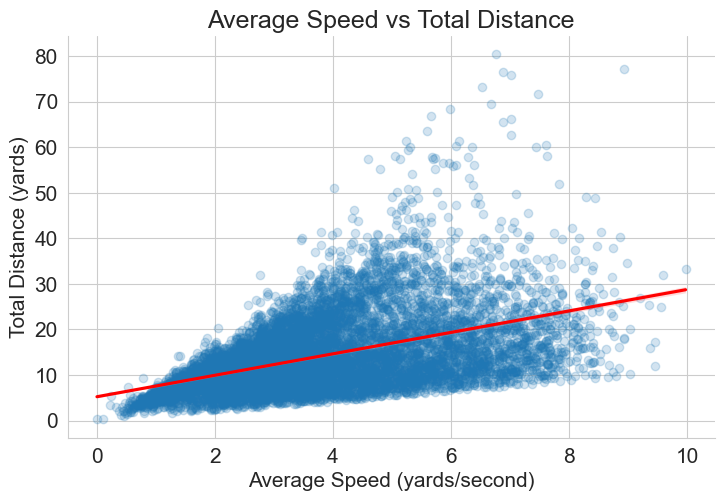

In [ ]:
plt.figure(figsize=(8, 6))
sns.lmplot(data=tracking_tackles, 
           x='avg_speed', 
           y='total_distance', 
           aspect=1.5, 
           scatter_kws={'alpha':0.2}, 
           line_kws={'color': 'red'}
          )
plt.title('Average Speed vs Total Distance')
plt.xlabel('Average Speed (yards/second)')
plt.ylabel('Total Distance (yards)')
plt.show()

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

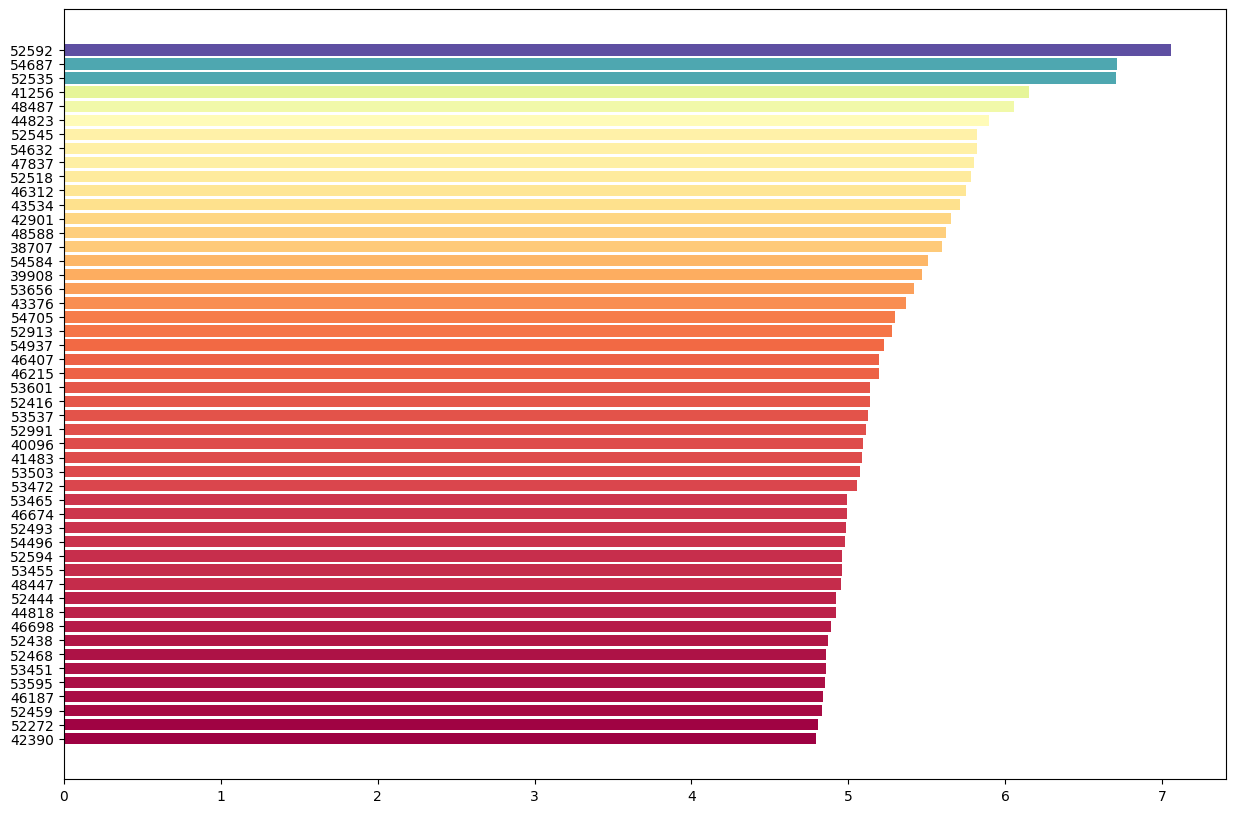

In [63]:
warnings.filterwarnings("ignore")

# Calculate the mean avg_speed for each nflId
nflid_speeds = tracking_tackles.groupby('nflId')['avg_speed'].mean().reset_index()

# Sort the nflIds by avg_speed in descending order and take the top 50
top_nflid_speeds = nflid_speeds.sort_values(by='avg_speed', ascending=False).head(50)

# Reverse the order of the data so that the highest values appear at the top of the plot
top_nflid_speeds = top_nflid_speeds.iloc[::-1]

# Create a color palette that corresponds to the avg_speed values
norm = plt.Normalize(top_nflid_speeds['avg_speed'].min(), top_nflid_speeds['avg_speed'].max())
colors = plt.cm.Spectral(norm(top_nflid_speeds['avg_speed']))

# Create the bar plot
plt.figure(figsize=(15, 10))
bars = plt.barh(top_nflid_speeds['nflId'].astype(str), top_nflid_speeds['avg_speed'], color=colors)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable
cbar = plt.colorbar(sm)
cbar.set_label('Average Speed (yards/second)')

# Add labels and title
plt.xlabel('Average Speed (yards/second)')
plt.ylabel('NFL ID')
plt.title('Top 50 NFL Tacklers by Average Speed')

# Show the plot
plt.show()

Top player for overall average speed when tackling.

In [64]:
players.query('nflId == 52592')

nflId height  weight birthDate collegeName position   displayName
1129  52592    6-1     333       NaN      Baylor       DT  Bravvion Roy

#### Total Distance

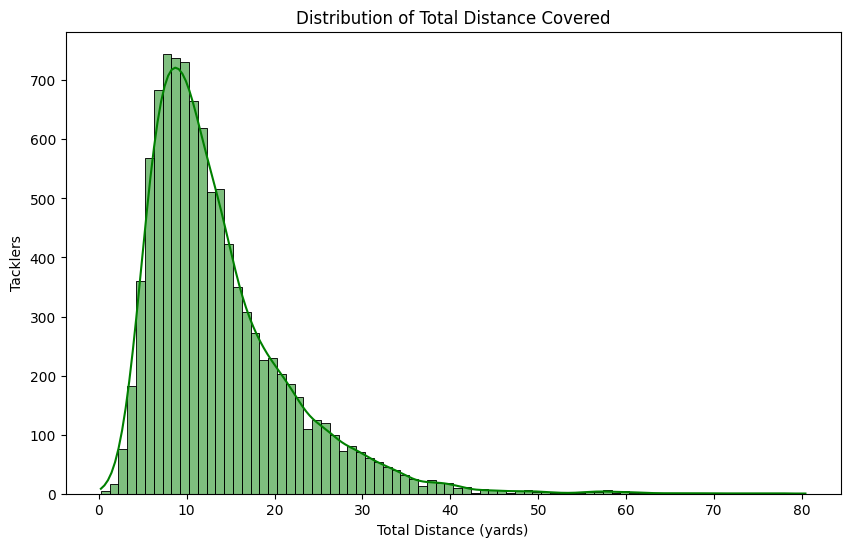

In [65]:
plt.figure(figsize=(10, 6))
sns.histplot(data=tracking_tackles, x='total_distance', bins=80, kde=True, color='green')
plt.title('Distribution of Total Distance Covered')
plt.xlabel('Total Distance (yards)')
plt.ylabel('Tacklers')
plt.show()

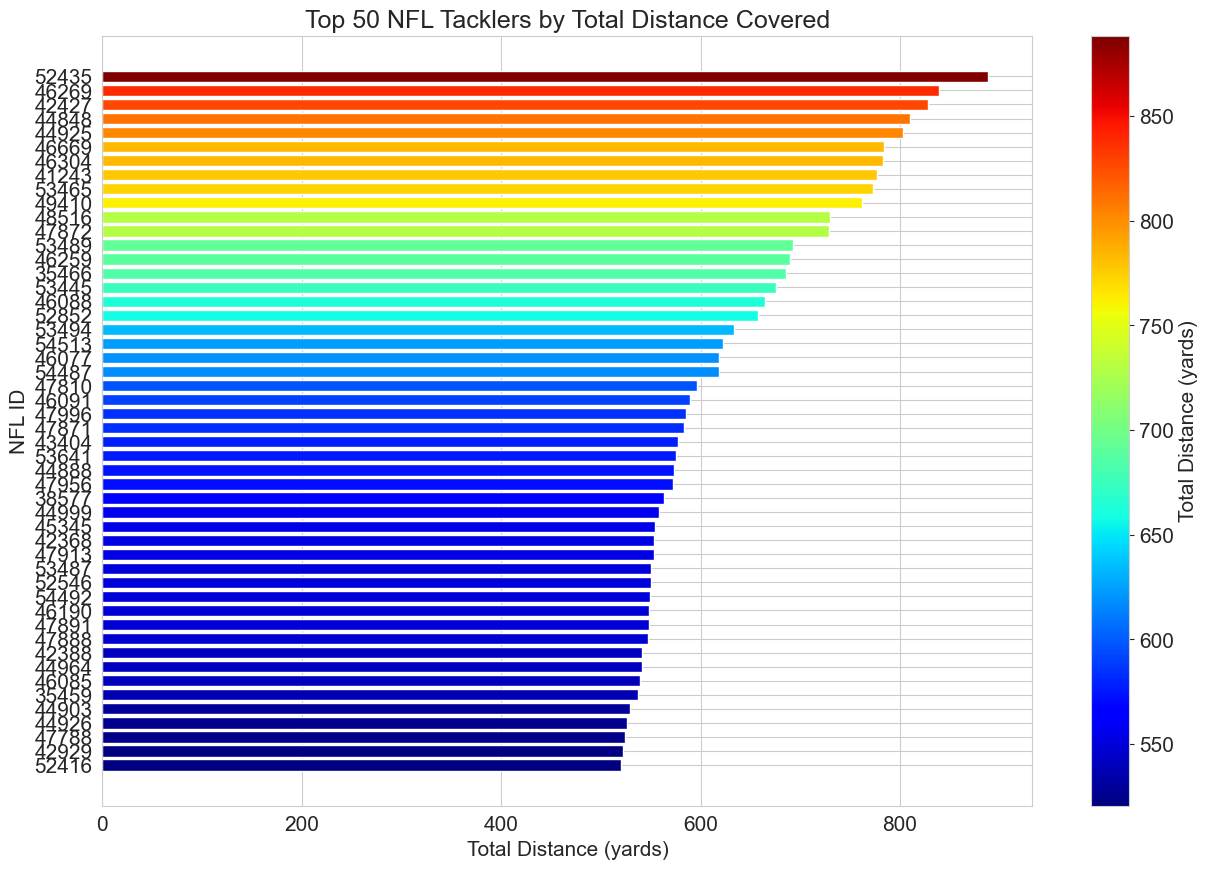

In [ ]:
# Calculate the sum of total_distance for each nflId
nflid_distances = tracking_tackles.groupby('nflId')['total_distance'].sum().reset_index()
top_nflid_distances = nflid_distances.sort_values(by='total_distance', ascending=False).head(50)
top_nflid_distances = top_nflid_distances.iloc[::-1]

norm = plt.Normalize(top_nflid_distances['total_distance'].min(), top_nflid_distances['total_distance'].max())
colors = plt.cm.jet(norm(top_nflid_distances['total_distance']))
plt.figure(figsize=(15, 10))
bars = plt.barh(top_nflid_distances['nflId'].astype(str), top_nflid_distances['total_distance'], color=colors)

sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Total Distance (yards)')

plt.xlabel('Total Distance (yards)')
plt.ylabel('NFL ID')
plt.title('Top 50 NFL Tacklers by Total Distance Covered')
plt.show()

Top tackler based on total distance covered for all tackles

In [ ]:
players.query('nflId == 52435')

nflId height  weight   birthDate collegeName position    displayName
1015  52435    6-1     245  1997-10-21  Texas Tech      ILB  Jordyn Brooks

#### Acceleration
In terms of physics, acceleration is a very important feature with regards to how much power is behind a tackle. Acceleration is defined as the change in velocity over time, and velocity is defined as the change in position over time. The force behind a tackle is proportional to the product of the acceleration and mass of the tackler, i.e Newton's Second Law of Motion:

F = ma

We will explore this further in the feature engineer section when we combine the players weight and acceleration to this dataset. The acceleration value extacted here from the tracking dataset was done so by taking the value of acceleration at the exact frame of the tackle. Let's take a closer look at this acceleration feature.

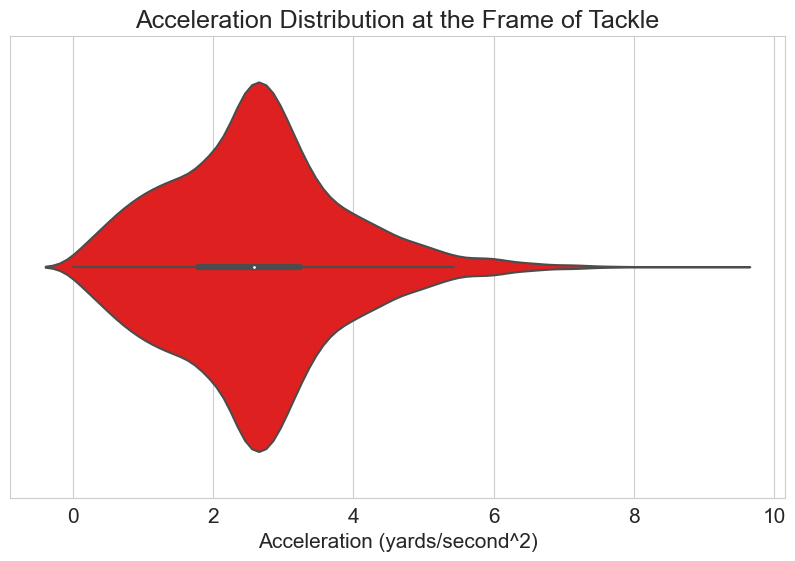

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=tracking_tackles, x='acceleration', color='red')
plt.title('Acceleration Distribution at the Frame of Tackle')
plt.xlabel('Acceleration (yards/second^2)')
plt.show()

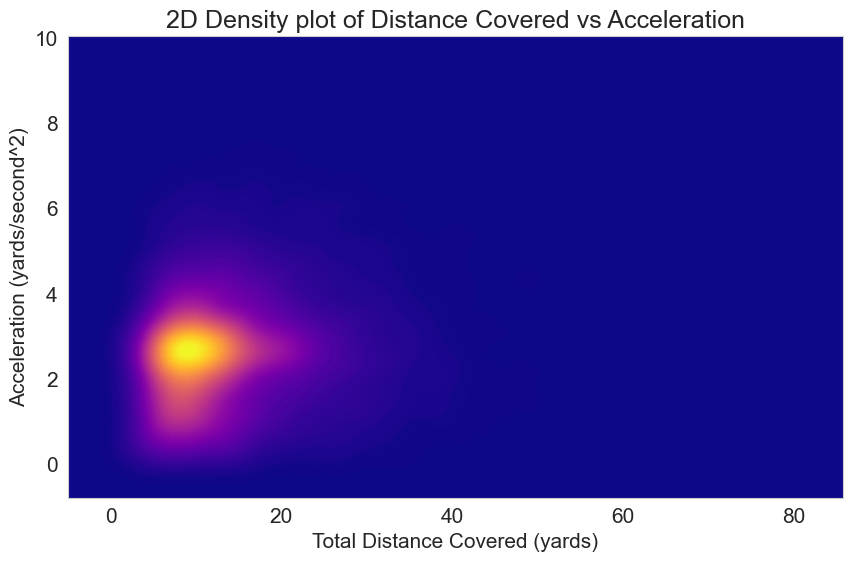

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=tracking_tackles, x='total_distance', y='acceleration', fill=True, thresh=0, levels=100, cmap="plasma")
plt.title('2D Density plot of Distance Covered vs Acceleration')
plt.xlabel('Total Distance Covered (yards)')
plt.ylabel('Acceleration (yards/second^2)')
plt.show()

The majority of tacklers taveled a distance of around 10 yards, with an acceleration of around 3 yards/second^2

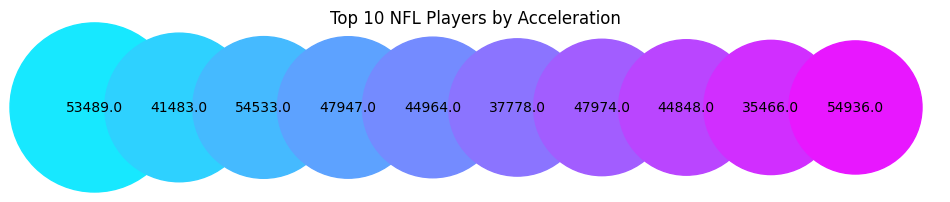

In [66]:
# Sort the tackles by the 10 largest accelerations
top_tackles_by_acceleration = tracking_tackles.nlargest(10, 'acceleration')

# Normalize the acceleration values to determine the size of the circles
top_tackles_by_acceleration['normalized_acceleration'] = (
    top_tackles_by_acceleration['acceleration'] / top_tackles_by_acceleration['acceleration'].max()) * 100
top_tackles_by_acceleration.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 8))
ax = plt.gca()
color_palette = sns.color_palette("cool", n_colors=10)

# Draw circles and label them with nflId
for i, (idx, row) in enumerate(top_tackles_by_acceleration.iterrows()):
    circle = plt.Circle((i, 0.5), row['normalized_acceleration'] * 0.01, color=color_palette[i], clip_on=False)
    ax.add_artist(circle)
    plt.text(i, 0.5, str(row['nflId']), ha='center', va='center', color='black')

# Let's set the limits and aspect to fit the circles
ax.set_xlim(-1, len(top_tackles_by_acceleration))
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
plt.title('Top 10 NFL Players by Acceleration', pad=30)
plt.show()

Pete Werner, an outside linebacker, has the highest tackle acceleration for this dataset

In [ ]:
players.query('nflId == 53489')

nflId height  weight birthDate collegeName position  displayName
1278  53489    6-3     242       NaN  Ohio State      OLB  Pete Werner

#### Horizontal and Vertical Displacements

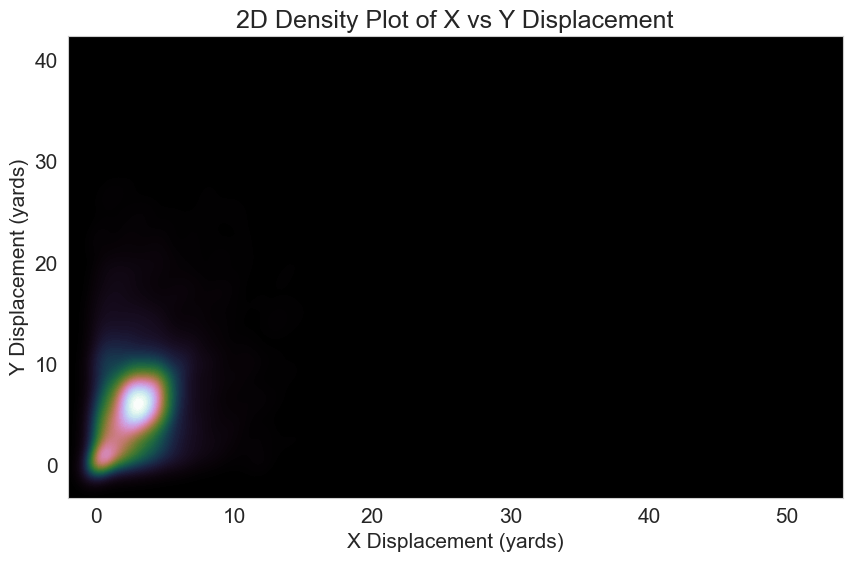

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=tracking_tackles, x='x_displacement', y='y_displacement', fill=True, thresh=0, levels=100, cmap="cubehelix")
plt.title('2D Density Plot of X vs Y Displacement')
plt.xlabel('X Displacement (yards)')
plt.ylabel('Y Displacement (yards)')
plt.show()

#### Interpretation

#### The average tackle requires more horizontal movement then vertical movement with respect to the line of scrimmage. The avereage defensive player in the NFL must be proficient in lateral movement in order to get consistent tackles.

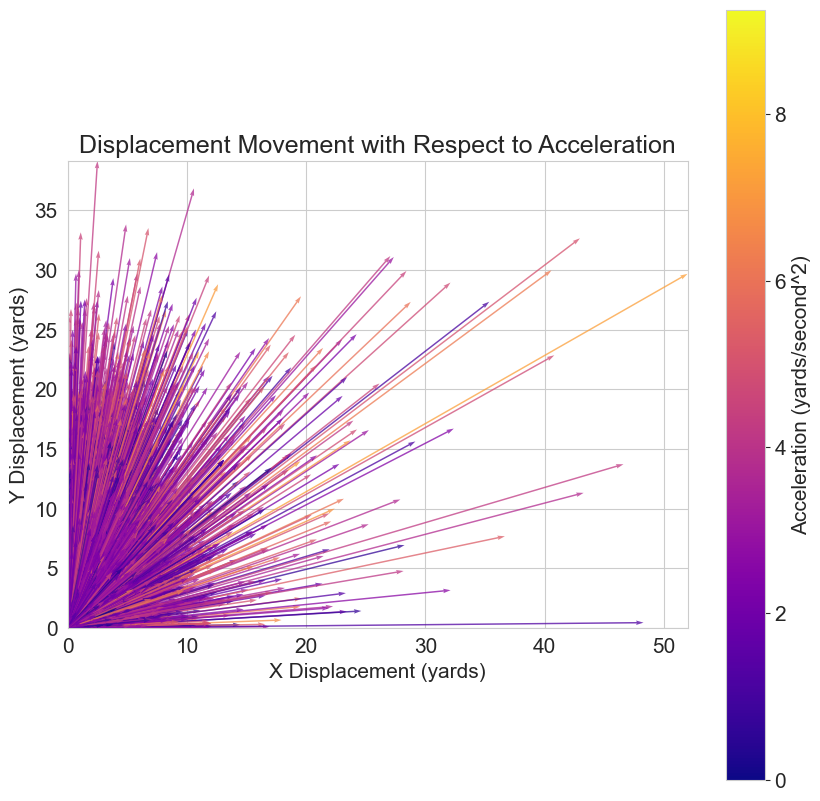

In [ ]:
# Normalize the acceleration for coloring
norm = plt.Normalize(tracking_tackles['acceleration'].min(), tracking_tackles['acceleration'].max())
colors = plt.cm.plasma(norm(tracking_tackles['acceleration']))  # Color map for acceleration

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the quiver plot with actual data
Q = ax.quiver(np.zeros(len(tracking_tackles)), np.zeros(len(tracking_tackles)),
              tracking_tackles['x_displacement'], tracking_tackles['y_displacement'],
              color=colors, angles='xy', scale_units='xy', scale=1, alpha=0.75)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Acceleration (yards/second^2)')

# Set the plot title and labels
ax.set_title('Displacement Movement with Respect to Acceleration')
ax.set_xlabel('X Displacement (yards)')
ax.set_ylabel('Y Displacement (yards)')
ax.grid(True)

# Set the axes limits based on the min and max of the displacement data
ax.set_xlim(tracking_tackles['x_displacement'].min(), tracking_tackles['x_displacement'].max())
ax.set_ylim(tracking_tackles['y_displacement'].min(), tracking_tackles['y_displacement'].max())
ax.set_aspect('equal')
plt.show()

#### Interpretation

There are a few things this chart implies. This still confirms our interpretation that the majority of tackles occur in the lateral direction, as the distributions are heavily focussed in the y-direction. The acceleration however, is not dependent on the direction, as there is an even distribution of acceleration magnitudes across both the 2D plane. Lastly, the magnitude of acceleration, is largely dependent on how much ground the player is able to cover. The higher acceleration values mainly reside in the 10 - 30 yard range. Remember that acceleration is not the same as velocity, this represents how much the player is getting faster and faster up to the moment of tackle. 

#### Orientation and Direction

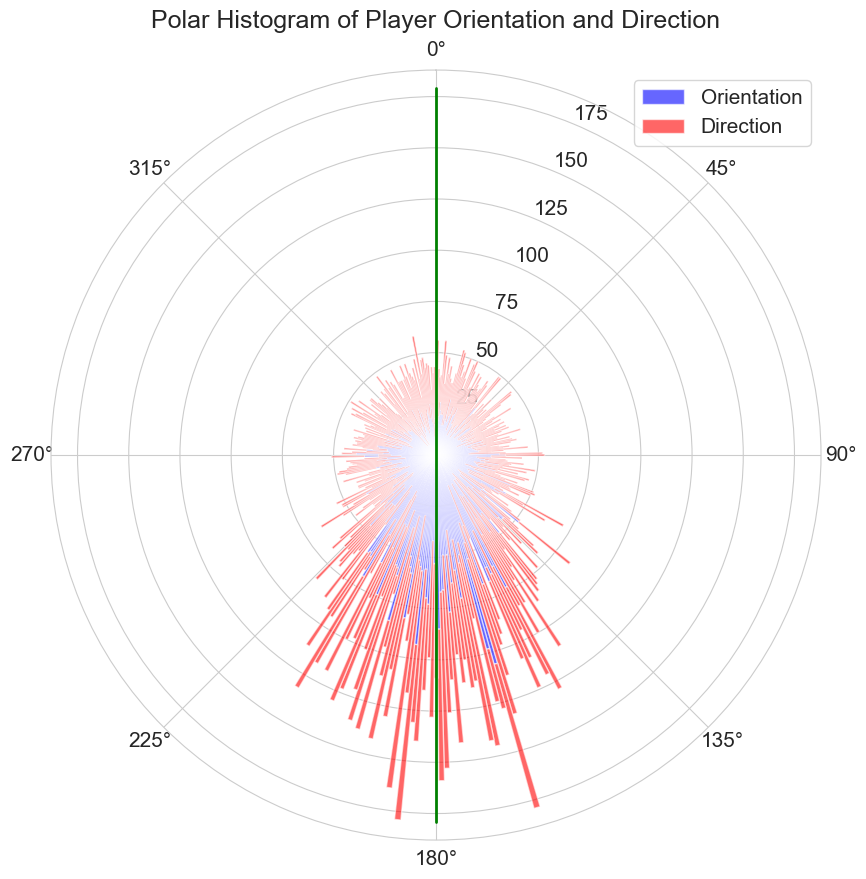

In [ ]:
# Convert degrees to radians for plotting
orientation_radians = np.deg2rad(tracking_tackles['orientation'])
direction_radians = np.deg2rad(tracking_tackles['direction'])

# Create a polar histogram (rose diagram) for orientation and direction
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Orientation histogram
orientation_hist, orientation_bins = np.histogram(orientation_radians, bins=360, range=(0, 2*np.pi))
ax.bar(orientation_bins[:-1], orientation_hist, width=orientation_bins[1]-orientation_bins[0],
       color='blue', alpha=0.6, label='Orientation')

# Direction histogram
direction_hist, direction_bins = np.histogram(direction_radians, bins=360, range=(0, 2*np.pi))
ax.bar(direction_bins[:-1], direction_hist, width=direction_bins[1]-direction_bins[0],
       color='red', alpha=0.6, label='Direction', bottom=orientation_hist)

# Add a solid line from 0 to 180 degrees, this represents the orientation of the line of scrimmage
ax.plot([0, np.pi], [max(orientation_hist + direction_hist)]*2, color='green', linewidth=2)

ax.set_title('Polar Histogram of Player Orientation and Direction', va='bottom')
ax.set_theta_zero_location('N')  # Set 0 degrees at the top
ax.set_theta_direction(-1)  # Set the direction of angles to clockwise
ax.legend(loc='upper right')
plt.show()

#### Insights

Looking at this polar histogram, the overwhelming majority of tackles occur in the direction of the home team's sideline, an important question to ask is, why? Why are tackles SO concentrated around the home team's sideline?? It's quite possible that the data indicating a concentration of tackles near the home team's sideline could be related to subconscious or strategic behaviors by the coaching staff. Here are a few potential reasons why this might occur:

1. **Subconscious Behavior**: Coaches might subconsciously favor the side of the field closest to them for ease of communication and observation. This proximity allows them to give clearer instructions and make more accurate assessments of the players' performance.

2. **Strategic Placement**: Coaches may deliberately run plays toward their sideline to have a better view of the action and to make real-time tactical decisions based on close-up observations of player matchups and opposition setups.

3. **Player Comfort**: Offensive players might be more comfortable executing plays on the side of the field where they feel support from their coaches and teammates on the sideline, leading to a higher frequency of actions in this area. This is a known subconsious behavior of quarterbacks that call their own plays. In the heat of a game, when a quarterback looks to one side with their home team and fans, they feel more comfortable running towards that direction.

4. **Field Conditions**: Sometimes the condition of the field may influence play direction. If one side of the pitch is in better condition or offers some sort of advantage (e.g., wind direction, sun position, slope), coaches might favor that side.

5. **Tactical Adjustments**: Opposing teams might be intentionally steering play towards the home sideline as part of their game plan, perhaps to isolate certain matchups or exploit space behind advancing players.

Understanding these patterns is crucial for football teams. If a team is consistently running plays to one side of the field, the predictability could be a disadvantage, as the opposition could adjust their defense to counter this tendency. Coaches and analysts might use this information to diversify play-calling, to prepare for opponents' potential adjustments, and to explore whether there are untapped opportunities on the less-utilized side of the field. This could be refined even more on a team by team basis in order to accurately predict the mindset of opposing coaches.

In terms of tactical analysis, this information could be very valuable. It may indicate that the home team should prepare for plays that challenge their ability to defend the sides of the pitch or that they should work on strategies that exploit the opposition's tendency to drive play toward the sidelines. Coaches might use this information to adjust their defensive shape or to train specific players to handle sideline plays more effectively. Not only that, but pay close attention to the total amount of tackles, represented by the magnitude of each bar, and notice that the direction of tackle mainly revolves around both sidelines, with hardly any orientations in the x direction. This means that defensive players are consistently facing and running in the horizontal directions at the time of tackle. 

## Plays Dataframe

In [67]:
plays_updated.describe().style.set_properties(**{'border': '1.5px solid blue'}).background_gradient(cmap='Blues')

#### Correlation Matrix

<Figure size 800x600 with 0 Axes>

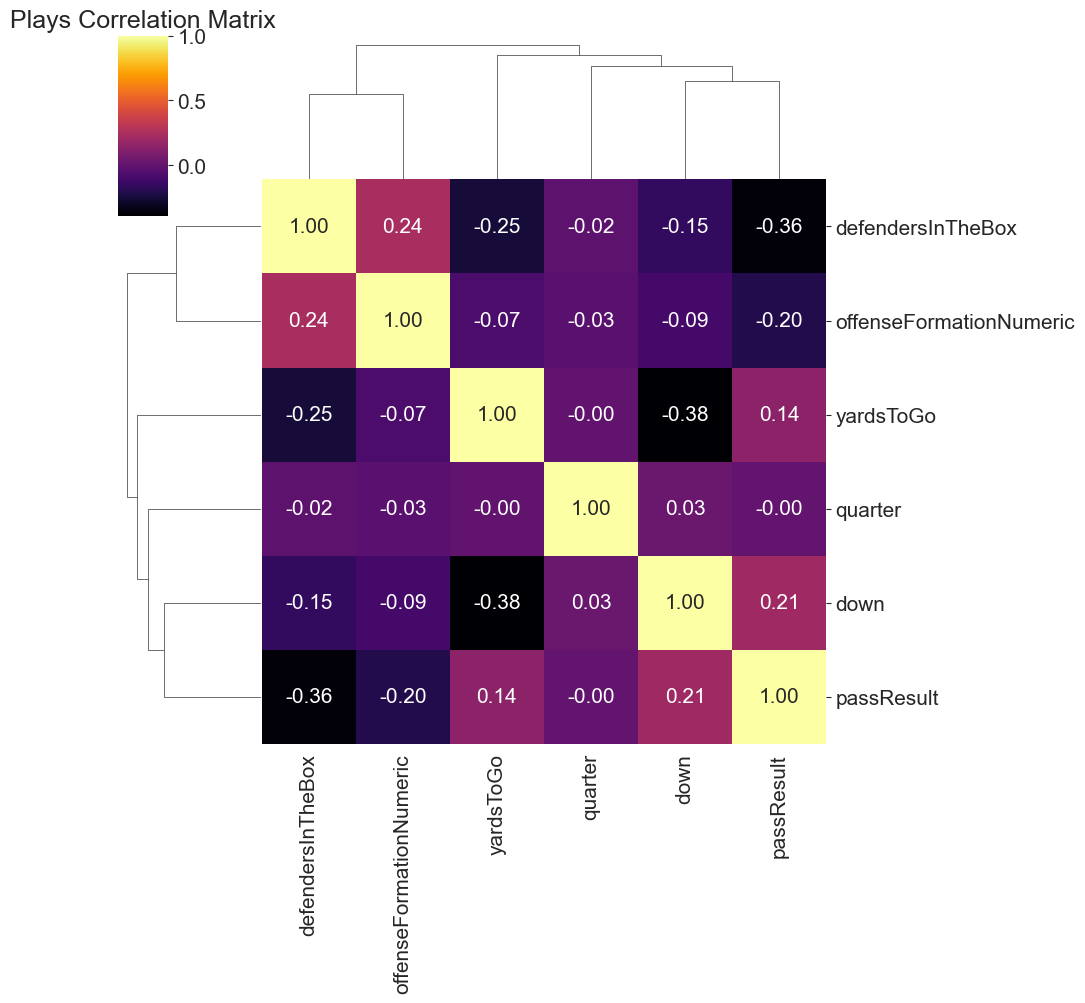

In [ ]:
plt.figure(figsize=(8, 6))

columns_to_plot = [col for col in plays_updated.columns if col not in ['gameId', 'playId', 'ballCarrierId', 'playDescription', 'possessionTeam', 'defensiveTeam', 'offenseFormation']]

corr_grid = plays_updated[columns_to_plot].corr()
sns.clustermap(
    corr_grid,
    cmap='inferno',
    xticklabels=corr_grid.columns,
    yticklabels=corr_grid.columns,
    annot=True, 
    fmt=".2f"
)

plt.title('Plays Correlation Matrix')
plt.show()

#### Quarter
Assuming that quarter 5 means overtime as it was not specified in the data dictionary.

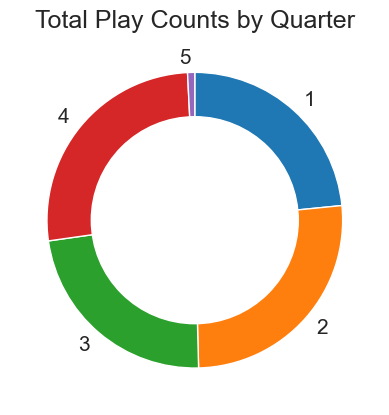

In [ ]:
# Calculate the play counts again just in case
quarter_counts = plays_updated.groupby('quarter')['playId'].count()

fig, ax = plt.subplots()
ax.pie(quarter_counts, labels=quarter_counts.index, startangle=90, counterclock=False, wedgeprops=dict(width=0.4))
ax.add_artist(plt.Circle((0,0),0.70,fc='white'))

plt.title('Total Play Counts by Quarter')
plt.show()

#### Offensive Formation

<Axes: xlabel='offenseFormation', ylabel='count'>

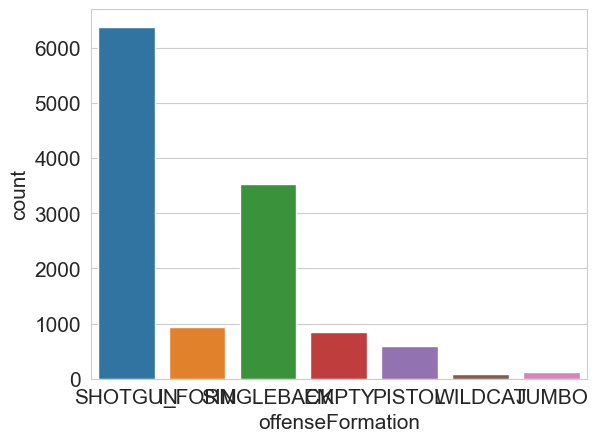

In [ ]:
sns.countplot(x='offenseFormation', data=plays_updated)

#### Defenders In The Box

<Axes: xlabel='defendersInTheBox', ylabel='count'>

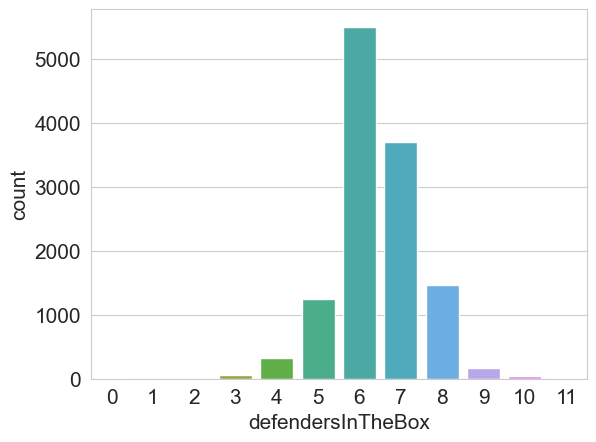

In [ ]:
sns.countplot(x='defendersInTheBox', data=plays_updated)

## Games Dataframe

In [ ]:
games_updated.describe().style.set_properties(**{'border': '1.5px solid red'}).background_gradient(cmap='Reds')

#### Correlation Matrix

<Figure size 800x600 with 0 Axes>

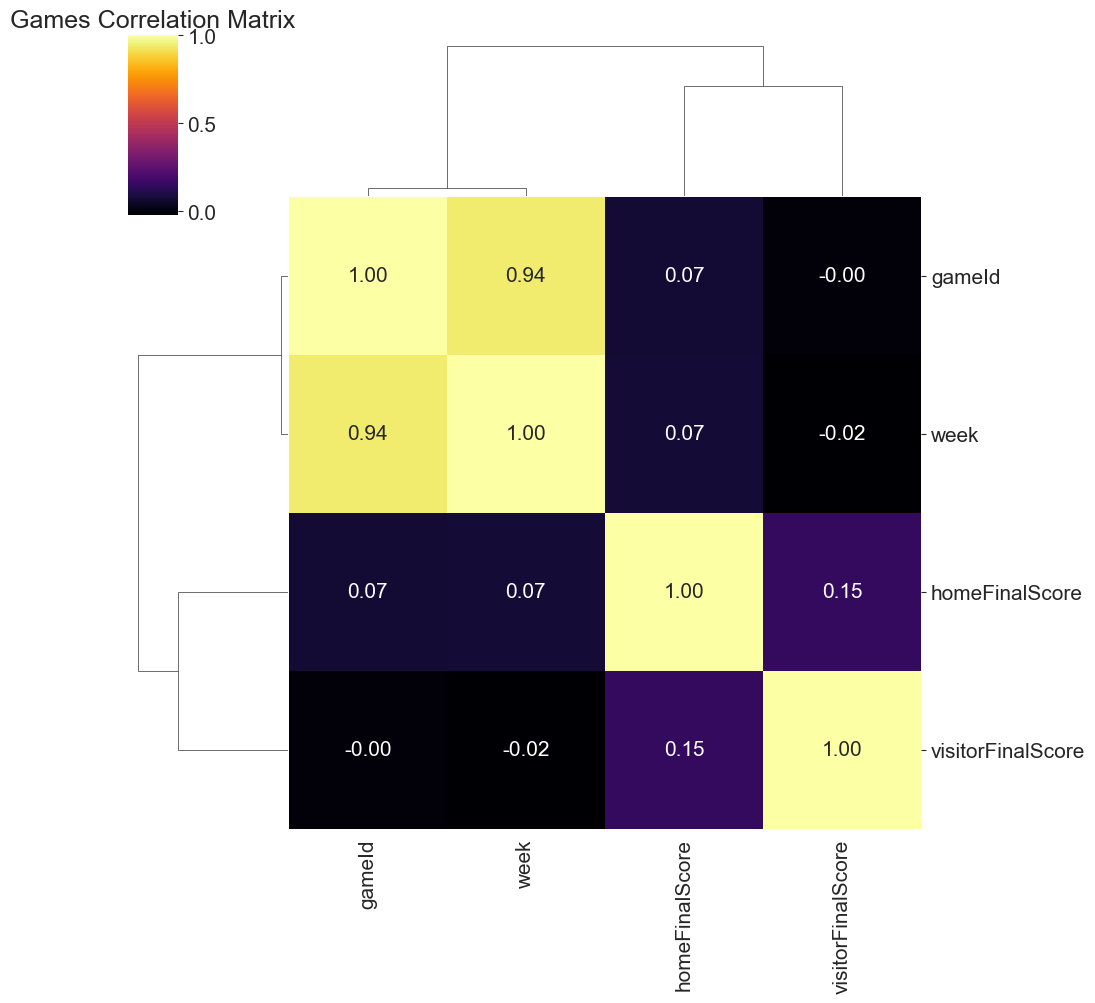

In [ ]:
plt.figure(figsize=(8, 6))

columns_to_plot = [col for col in games_updated.columns if col not in ['gameDate', 'homeTeamAbbr', 'visitorTeamAbbr']]

corr_grid = games_updated[columns_to_plot].corr()
sns.clustermap(
    corr_grid,
    cmap='inferno',
    xticklabels=corr_grid.columns,
    yticklabels=corr_grid.columns,
    annot=True, 
    fmt=".2f"
)

plt.title('Games Correlation Matrix')
plt.show()

## Tackles Dataframe

In [ ]:
tackles.describe().style.set_properties(**{'border': '1.5px solid orange'}).background_gradient(cmap='Oranges')

#### Correlation Matrix

<Figure size 800x600 with 0 Axes>

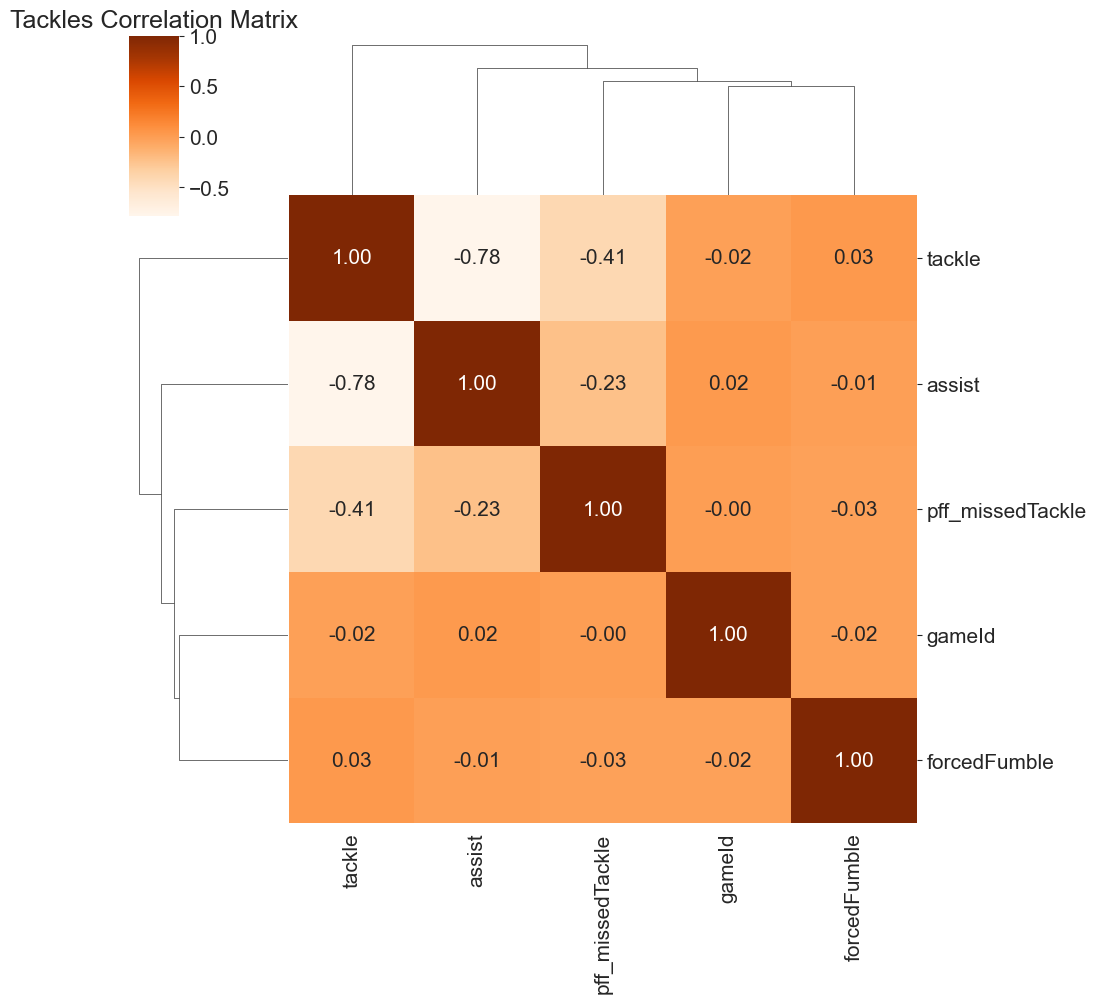

In [ ]:
plt.figure(figsize=(8, 6))

columns_to_plot = [col for col in tackles.columns if col not in ['gameDate', 'playId', 'nflId']]

corr_grid = tackles[columns_to_plot].corr()
sns.clustermap(
    corr_grid,
    cmap='Oranges',
    xticklabels=corr_grid.columns,
    yticklabels=corr_grid.columns,
    annot=True, 
    fmt=".2f"
)

plt.title('Tackles Correlation Matrix')
plt.show()

#### Tackle Type Frequencies

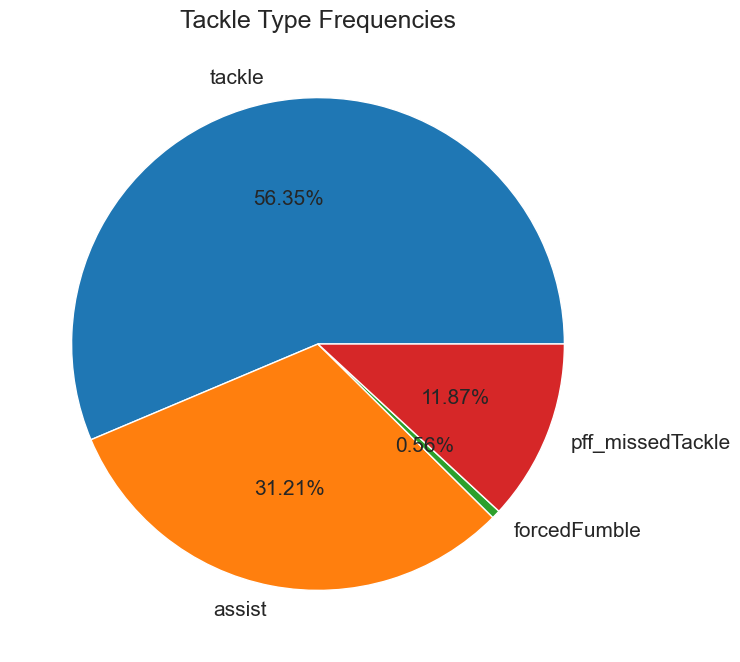

In [ ]:
frequencies = {'tackle': tackles.tackle.sum(), 'assist': tackles.assist.sum(), 'forcedFumble': tackles.forcedFumble.sum(), 'pff_missedTackle': tackles.pff_missedTackle.sum()}

plt.figure(figsize=(10,8))
plt.pie(
    frequencies.values(), 
    labels = frequencies.keys(), 
    autopct='%0.2f%%'
)
plt.title('Tackle Type Frequencies')
plt.show()

According to the NFL, a tackle is awarded to any defensive player who brings down the ball carrier to end a play. Only one player can be credited with a solo tackle on a single play, while other players who helped in the tackle are credited with an assisted tackle.

## Feature Selection & Merging

Let's add some features from the other dataframes into the main dataframe so we can have one consolidated dataframe. This will allow us to dive even deeper into the data and pull insights based on unseen correlations. We need to prep this dataframe for machine learning by getting as many relavent features (for tackles) as we can. Let's first start by dropping the non-nummeric features for machine learning.

In [68]:
main_df = main_df.drop(columns=['team', 'event'])

#### Plays 

In [69]:
# Now we merge the dataframes on 'gameId' and 'playId'
main_df = main_df.merge(
    plays_updated[['gameId', 'playId', 'ballCarrierId', 'passResult', 'defendersInTheBox', 'offenseFormationNumeric']],
    on=['gameId', 'playId'],
    how='left'
)

In [70]:
main_df.head().style.set_properties(**{'border': '1.5px solid red'}).background_gradient(cmap='plasma')

#### Players 
The players dataframe holds 3 features that can be of value for predicting whether or not a tackle is going to occur: position, height, and mass. Let's create a force profile for each player since we have an acceleration and a weight. But there is a catch, we need to only do it for frames where the actual tackle occured, a lambda function should take care of this. We'll use Newton's Second Law of Motion for this:

F = ma (kg * (m/s^2))

In [71]:
# Merge the 'mass', 'position_numeric', and 'height_inches' from players_updated into main_df based on 'nflId'
main_df = main_df.merge(
    players_updated[['nflId', 'weight', 'position_numeric', 'height_inches']], 
    on='nflId', 
    how='left'
)

In [72]:
# Conversion factors
yard_to_meter = 0.9144  # 1 yard is 0.9144 meters
pound_to_kg = 0.453592  # 1 pound is 0.453592 kilograms

# Apply the force calculation only when tackle equals 1, otherwise set the force to 0, create new feature 'force'
main_df['force'] = main_df.apply(
    lambda row: (row['acceleration'] * yard_to_meter) * (row['weight'] * pound_to_kg) if row['tackle'] == 1 else 0,
    axis=1
)
    
# Let's display the rows where the dataframe equals 1 for tackle to get a better idea of each tackle's force profile
main_df[main_df['tackle'] == 1].head(10).style.set_properties(**{'border': '1.5px solid black'}).background_gradient(cmap='binary')

#### Tackles

In [73]:
main_df = main_df.merge(
    tackles[['gameId', 'playId','nflId', 'assist', 'forcedFumble', 'pff_missedTackle']], 
    on=['gameId', 'playId', 'nflId'], 
    how='left'
)

In [74]:
main_df.replace(np.NaN, 0, inplace=True)

# Check to make sure all null values in these column where switched to 0
print(main_df.assist.unique())
print(main_df.forcedFumble.unique())
print(main_df.pff_missedTackle.unique())

[0. 1.]
[0. 1.]
[0. 1.]


In [75]:
main_df['assist'] = main_df['assist'].astype('int64')
main_df['forcedFumble'] = main_df['forcedFumble'].astype('int64')
main_df['pff_missedTackle'] = main_df['pff_missedTackle'].astype('int64')

main_df.head().style.set_properties(**{'border': '1.5px solid red'}).background_gradient(cmap='plasma')

## Feature Engineering
Now that we have selected the features we want for this dataset, let's engineer some of our own features that would provide valuable insight into the nature of each tackle. It's not a gurantee that all of these will make it to the final model, currently this is a section for experimentation, and we may end up using all of them or none of them depending on how well they perform.

**Feature 1: Player Load**

Player Load is a combination of distance, speed, and acceleration. This metric can be indicative of fatigue and could correlate with the likelihood of a missed tackle or the effectiveness of a tackle. For simplicity, we can define it as the product of distance and the average of speed and acceleration.

$$
{\text{load}} = ({\text{distance}} * {\text{speed}}) + ({\text{acceleration}\over2})
$$

In [76]:
main_df['load'] = main_df['distance'] * (main_df['speed'] + main_df['acceleration']) / 2

**Feature 2: Interaction Proximity**

A smaller distance might indicate a higher chance of a tackle. For simplicity, let's assume that we have the x, y positions of the ball carrier at the time of the tackle.

The Euclidean distance \( d \) between a player and the ball carrier is calculated as:

$$
d = \sqrt{(x_{\text{player}} - x_{\text{ball carrier}})^2 + (y_{\text{player}} - y_{\text{ball carrier}})^2}
$$

In [77]:
# Function to calculate the Euclidean distance between two points in time for each player
def calculate_euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Function to calculate the distance to the ball carrier for each player in each frame of each play
def calculate_distances_to_ball_carrier(df):
    # Initialize the new column for distance to ball carrier
    df['distance_to_ball_carrier'] = np.nan

    # Iterate over each unique play and frame
    for (updated_play_id, frame_id), frame_group in df.groupby(['updated_playId', 'frameId']):
        # Find the ball carrier's position in the current frame
        ball_carrier_row = frame_group[frame_group['nflId'] == frame_group['ballCarrierId'].iloc[0]].iloc[0]
        
        # Compute the distance from each player to the ball carrier in the current frame
        for idx, player_row in frame_group.iterrows():
            player_x = player_row['x']
            player_y = player_row['y']
            ball_carrier_x = ball_carrier_row['x']
            ball_carrier_y = ball_carrier_row['y']
            
            # Calculate the Euclidean distance
            distance = calculate_euclidean_distance(player_x, player_y, ball_carrier_x, ball_carrier_y)
            # Update the distance to ball carrier
            df.at[idx, 'distance_to_ball_carrier'] = distance

    return df

main_df = calculate_distances_to_ball_carrier(main_df)

**Feature 3: Tackle Opportunity Window (TOW)** 

WIth this dataset being on a frame by frame basis, it presents a unique opportunity to calculate a window of opportunity for each defensive player to tackle the ball carrier, more specifically the "Tackle Opportunity Window". The TOW is the maximum number of consecutive frames a player is within the tackle distance threshold of the ball carrier. This metric is a very good indicator at determining which tacklers exceed at following the movements of the ball carrier in order to minimize the gap between them and their target. It's calculated by iterating through each play and player, counting the consecutive frames where the player is within the specified distance of the ball carrier, and recording the maximum count. It essentially calculates each player based on how close they are to the ball carrier and scores them based on how long they are within a certain distance of the ball carrier. Optimizing a function like this, especially for large datasets, can be challenging. To speed up the process, we can try a more vectorized approach, which tends to be more efficient in Pandas. This allows us to avoid deep nested loops that would have to iterate and calculate over 11 million rows of data. Pandas is built off of C, which is many magnitudes faster than Python. Our calculations for this feature should take only a few seconds compared to multiple hours. Note that we will filter for defensive players and only score them once we are ready for final feature selection.

In [78]:
# This is an optimized version using pandas' capabilities for vectorized operations
def calculate_tow_vectorized(df, distance_threshold):
    
    # Creates a binary column indicating if the player is within tackle distance
    df['within_tackle_distance'] = (df['distance_to_ball_carrier'] <= distance_threshold).astype(int)

    # Group by play and player and calculate the cumulative sum of 'within_tackle_distance'
    # This sum will reset to 0 every time a player is outside the tackle distance
    df['cumulative_sum'] = df.groupby(['updated_playId', 'nflId'])['within_tackle_distance'].cumsum()
    df['cumulative_sum'] -= df.groupby(['updated_playId', 'nflId', df['within_tackle_distance'].eq(0).cumsum()])['cumulative_sum'].cummin()

    # Now, the max of 'cumulative_sum' within each group is the TOW
    df['tow'] = df.groupby(['updated_playId', 'nflId'])['cumulative_sum'].transform('max')

    # Drop the temporary columns
    df.drop(['within_tackle_distance', 'cumulative_sum'], axis=1, inplace=True)

    return df

# Call our function on the main dataframe and set the TOW to 2 yards
main_df = calculate_tow_vectorized(main_df, 2) # the threshold can be adjusted by experimenting for an optimal value

**Feature 4: Tackle Opportunity Window Ratio**

The tow score on it's own is valuable when comparing each player within a single play, however in the context of every tackle over a 9 week period, it does not properly represent each player as plays that are longer will yield a higher score even if the tackler is next to the ball carrier for half of the frames. Therefore we need create another feature that represents the ratio. The TOW ratio require the TOW value for each player, therefore TOW will be added to the main dataframe as well as the ratio.

In [79]:
# Calculate the number of frames per play
frame_counts = main_df.groupby('updated_playId').apply(lambda x: x.shape[0] / x['nflId'].nunique())
frame_counts = frame_counts.rename('frame_count_per_play')

# Merge the frame count back into the main dataframe
main_df = main_df.merge(frame_counts, on='updated_playId', how='left')

# Calculate the tow_ratio
main_df['tow_ratio'] = main_df['tow'] / main_df['frame_count_per_play']

# Drop the 'frame_count_per_play' column as it is no longer needed
main_df.drop(columns=['frame_count_per_play'], inplace=True)

In [ ]:
main_df.head().style.set_properties(**{'border': '1.5px solid red'}).background_gradient(cmap='plasma')

## Final Feature Selection
Let's select the features that we think will be most relavent to the model after we have looked at the features in the EDA phase. Multiple feature importance iterations were calculated and so far the optimal set of features are as follows:

In [80]:
model_df = main_df[['tackle', 'tow_ratio', 'orientation', 'direction', 'speed', 'acceleration', 'distance_to_ball_carrier', 'position_numeric', 'defendersInTheBox' , 'offenseFormationNumeric', ]]

#### Filter dataset for defensive players

In [81]:
# List of numeric codes for defensive positions
defensive_positions = [4, 5, 6, 7, 9, 10, 11, 14, 15, 18]

# Filter model_df to include only rows with defensive position codes
model_df = model_df[model_df['position_numeric'].isin(defensive_positions)]
model_df = model_df.reset_index(drop=True)

In [82]:
model_df.head().style.set_properties(**{'border': '1.5px solid red'}).background_gradient(cmap='viridis')

#### Check For Multicollinearity

<Figure size 800x600 with 0 Axes>

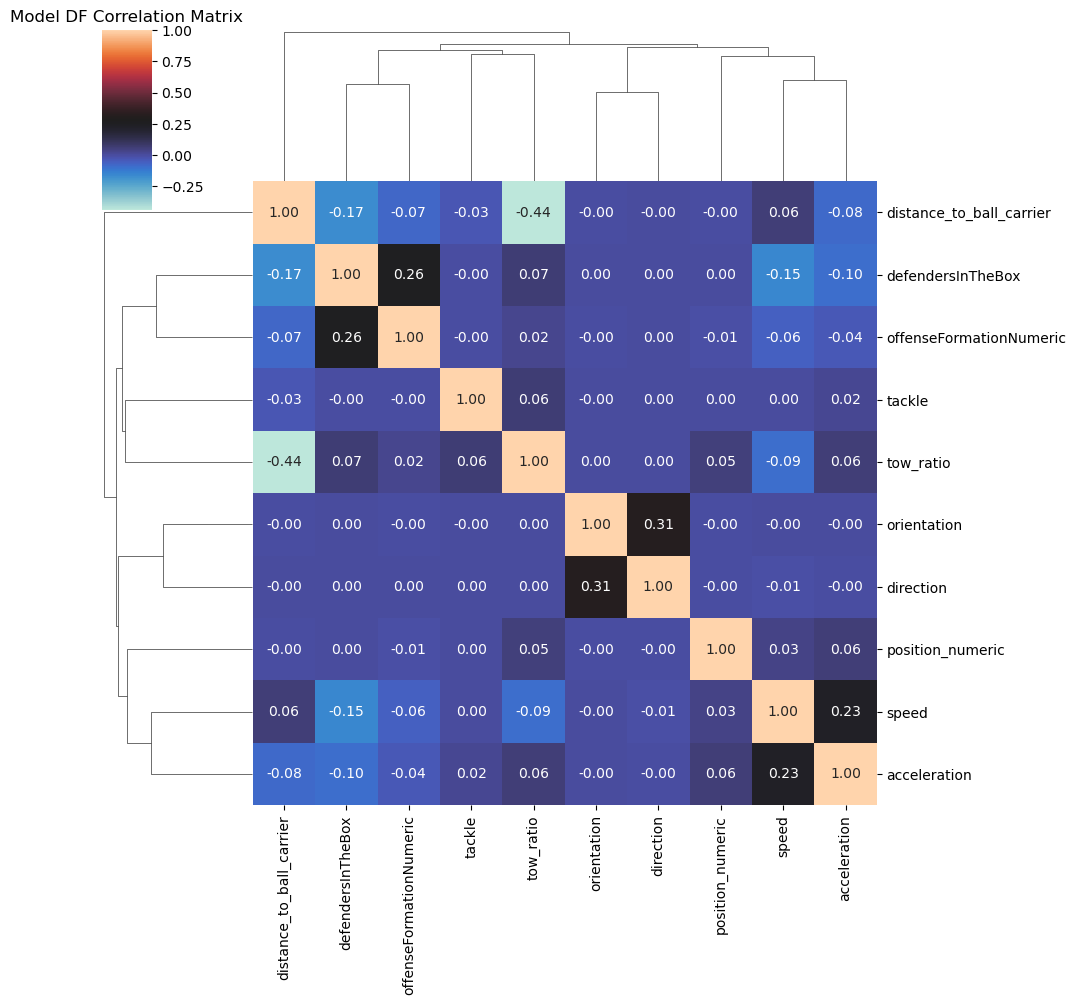

In [ ]:
plt.figure(figsize=(8, 6))

corr_grid = model_df.corr()
sns.clustermap(
    corr_grid,
    cmap='icefire',
    xticklabels=corr_grid.columns,
    yticklabels=corr_grid.columns,
    annot=True, 
    fmt=".2f"
)

plt.title('Model DF Correlation Matrix')
plt.show()

## Deep Learning
Due to the complex nature of this project, and all the subtle intricacies of each feature, a neural network is the best canidate for model creation. The following network is going to be built using TensorFlow, where each parameter will need to be accounted for in order to create as accurate of a model as possible. After careful evaluation and running through iterations of different features, the model_df contains all of the most relavent features used to predict the probability of a tackle. It might seem surprising that direction and orientation both made the list, but this can be related to how complex a neural network is and how proficient it is at picking consistent and subtle changes to features in order to follow a pattern, and the direction and orientation feature have a lot of variation between each frame. The longest and most important part of this network is the hyperparameter tuning, fortunately keras has a module that automates feature tuning within a set of given parameters. In order to capture all of the intricacies of this dataset, we are going to create a model with at least 5 hidden layers (not including the input and output layers) and set the objective to validation loss in order to confirm our model is not overfitting. This is where to "deep" in deep learning comes from. When the tuner is done running itterations and it has filtered down to the final set (the best parameters), it will do so by choosing the best model with the lowest validation loss. We are choosing validation loss as the objective over the validation accuracy due to the nature of this dataset and target variable we are analyzing (tackles). Take note here that training accuracy and training loss does not provide significant insight into the quality of the model, the validation loss and validation accuracy are the metrics used to determine how accurate a model predicts test data. We will still create a plot that shows the comparison of the training and validation sets, but the focus of how accurate the model is should be directed towards the validation sets.

#### Embedding

In [ ]:
# Re-encode 'position_numeric' to have continuous values starting from 0 as we filtered the main_df for defensive players
model_df['position_numeric'], _ = pd.factorize(model_df['position_numeric'])

# Update the number of unique positions
num_positions = model_df['position_numeric'].nunique()
positions = model_df['position_numeric']
positions_train, positions_test = train_test_split(positions, test_size=0.2, random_state=6, stratify=model_df['tackle'])

# Check the maximum index value again, it should go from 0-9 (10 values)
max_position_index_train = positions_train.max()
print("Unique positions:", num_positions)
print("Max position index in training data:", max_position_index_train)

Unique positions: 10
Max position index in training data: 9


#### Deep Neural Network

In [ ]:
warnings.filterwarnings("ignore") 

# Set a random seed value for reproducability
seed_value= 6
os.environ['PYTHONHASHSEED']=str(seed_value) # ensures the hash operation is reproducible for consistent behavior
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# We need to tell the neural network what is a categorical variable and what is a continuous value
positions = model_df['position_numeric'].astype(int)
formations = model_df['offenseFormationNumeric'].astype(int)
defenders = model_df['defendersInTheBox'].astype(int)

# Standardize the numerical features for training
numerical_features = model_df.drop(['tackle', 'position_numeric', 'offenseFormationNumeric', 'defendersInTheBox'], axis=1)
scaler = StandardScaler()
numerical_features = scaler.fit_transform(numerical_features)

X_train_num, X_test_num, positions_train, positions_test, formations_train, formations_test, defenders_train, defenders_test, y_train, y_test = train_test_split(
    numerical_features, positions, formations, defenders, model_df['tackle'], test_size=0.2, random_state=6, stratify=model_df['tackle'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define the size of the input for the embedding layers
num_positions = positions.nunique()
num_formations = formations.nunique()

# Define the size of the embeddings based on position and formation (categoricals)
embedding_size_position = 6  
embedding_size_formation = 3  

# Input layers
position_input = Input(shape=(1,), name='position_input')
offense_formation_input = Input(shape=(1,), name='offense_formation_input')
defenders_input = Input(shape=(1,), name='defenders_input')
numerical_input = Input(shape=(X_train_num.shape[1],), name='numerical_input')

# Embedding layers
position_embedding = Embedding(num_positions, embedding_size_position, input_length=1)(position_input)
offense_formation_embedding = Embedding(num_formations, embedding_size_formation, input_length=1)(offense_formation_input)

# Flatten the embeddings
position_embedding_flat = Flatten()(position_embedding)
offense_formation_embedding_flat = Flatten()(offense_formation_embedding)

# Concatenate embeddings 
concatenated_features = Concatenate()([
    position_embedding_flat, 
    offense_formation_embedding_flat, 
    defenders_input,  
    numerical_input
])

# Hypermodel definition
def build_model(hp):
    # Input layers
    position_input = Input(shape=(1,), name='position_input')
    offense_formation_input = Input(shape=(1,), name='offense_formation_input')
    defenders_input = Input(shape=(1,), name='defenders_input')
    numerical_input = Input(shape=(X_train_num.shape[1],), name='numerical_input')

    # Embedding layers with tunable sizes
    position_embedding = Embedding(num_positions, hp.Int('embedding_size_position', min_value=3, max_value=10, step=1), input_length=1)(position_input)
    offense_formation_embedding = Embedding(num_formations, hp.Int('embedding_size_formation', min_value=3, max_value=10, step=1), input_length=1)(offense_formation_input)

    # Flatten embeddings
    position_embedding_flat = Flatten()(position_embedding)
    offense_formation_embedding_flat = Flatten()(offense_formation_embedding)

    # Concatenate features
    concatenated_features = Concatenate()([position_embedding_flat, 
                                           offense_formation_embedding_flat, 
                                           defenders_input, 
                                           numerical_input])
    
    """
    Layers: this is one of the most important parts of the deep learning process and where the layers will be refined over 
    and over until a desired output is achieved, many combinations must addressed in order to find the optimal combination, 
    this is the heart of the neural network hyperparameter tuning process, and by far the most time consuming. This 
    hyperparameter tuning process can be more efficiently calibrated through the use of the Keras Tuner which is designed
    to find the optimal hyperparameters for the given intervals.
    """
    
    hidden_layer = concatenated_features

    # Tunable number of layers and units
    for i in range(hp.Int('num_layers', 1, 5)):
        hidden_layer = Dense(hp.Int('units_' + str(i), min_value=32, max_value=256, step=32), activation='relu')(concatenated_features if i == 0 else hidden_layer)
        dropout_rate = hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)
        hidden_layer = tf.keras.layers.Dropout(dropout_rate)(hidden_layer)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(hidden_layer) # output a binary value

    # Model assembly
    model = Model(inputs=[position_input, 
                          offense_formation_input, 
                          defenders_input,  
                          numerical_input], outputs=output_layer)

    # Compile the model with tunable learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Tuner configuration, this is the default tuner to use but is very time consuming and cost a lot of resources
# This tuner was used first but has taken too long, so we'll use a tuner that sets specific boundries
# tuner = kt.Hyperband(build_model, 
                     # objective='val_loss', # this is the main focus of the model due to the dataset's nature
                     # max_epochs=30, 
                     # factor=3,
                     # directory='NFL_ANN_Models', # save the tuner to the cwd for callbacks   
                     # project_name='Hyperparameter_Tuning_Run2') # update number before each run

# Since the tuner has gone on for over 4 days and there isn't much improvement, we will use this to speed up the process
tuner = RandomSearch(build_model, 
                     objective='val_loss', # this is the main focus of the model due to the dataset's nature
                     max_trials=25, 
                     executions_per_trial=1,
                     directory='NFL_ANN_Models', # save the tuner to the cwd for callbacks   
                     project_name='Hyperparameter_Tuning_Run4') # update number before each run

# Create a log directory with a timestamp to have a unique directory for each run
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

"""
Callbacks: This is the most importanct section for evaluating the performace of the model. Here we are creating;

Early Stopping Callback: This is used to stop the iterations when the model declines or plateaus
Model Checkpoint Callback: Used to monitor the current-most-optimal epoch based on validation loss and save it
TensorBoard Callback: Creates a separate dashboard with detailed performance analytics
"""

# Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=10, 
                                        verbose=1)
# Model Checkpoint Callback
model_checkpoint_callback = ModelCheckpoint('best_model.h5', 
                                            monitor='val_loss', 
                                            save_best_only=True, 
                                            verbose=1)
# TensorBoard Callback with datetime format
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, 
                                   histogram_freq=1)
# Combine all callbacks into a single list
ANN_callbacks = [early_stopping_callback, 
                 model_checkpoint_callback, 
                 tensorboard_callback]

# Start the hyperparameter search
tuner.search([positions_train, formations_train, defenders_train, X_train_num], y_train,
             epochs=15, 
             validation_split=0.1,
             callbacks=[early_stopping_callback])

# Identify the optimal hyperparameters to use in model training
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the model with the best hyperparameters
model = build_model(best_hps)
history = model.fit(
    [positions_train, formations_train, defenders_train, X_train_num], y_train,
    epochs=15, # ensure this matches the tuner search parameter
    validation_split=0.1, # split 10 percent of the data to validate the model
    callbacks=ANN_callbacks, # insert callbacks
    class_weight=class_weights_dict, # insert class weights
    verbose=1
)

# Evaluate the model
evaluation = model.evaluate([positions_test, formations_test, defenders_test, X_test_num], y_test)
print(f'Test loss: {evaluation[0]}') 
print(f'Test accuracy: {evaluation[1]}')

# Run tensorboard --logdir=logs/fit in the working directory command prompt to gain access to the full dashboard
# Then navigate to http://localhost:6006 to see performances

Trial 25 Complete [02h 39m 14s]
val_loss: 0.007045711390674114

Best val_loss So Far: 0.007011960726231337
Total elapsed time: 3d 16h 37m 48s
Epoch 1/15
131151/131157 [============================>.] - ETA: 0s - loss: 0.3858 - accuracy: 0.7767
Epoch 1: val_loss improved from inf to 0.48143, saving model to best_model.h5
131157/131157 [==============================] - 720s 5ms/step - loss: 0.3858 - accuracy: 0.7767 - val_loss: 0.4814 - val_accuracy: 0.7366
Epoch 2/15
131149/131157 [============================>.] - ETA: 0s - loss: 0.3715 - accuracy: 0.7638
Epoch 2: val_loss improved from 0.48143 to 0.39820, saving model to best_model.h5
131157/131157 [==============================] - 718s 5ms/step - loss: 0.3715 - accuracy: 0.7638 - val_loss: 0.3982 - val_accuracy: 0.7654
Epoch 3/15
131152/131157 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.7608
Epoch 3: val_loss did not improve from 0.39820
131157/131157 [==============================] - 717s 5ms/step - lo

#### Extract The Best Model

In [ ]:
best_model = load_model('best_model.h5')

# Standardize the numerical features separately for training and testing sets
scaler = StandardScaler()
numerical_features_train = scaler.fit_transform(X_train_num)
numerical_features_test = scaler.transform(X_test_num)

# Evaluate the best model on the test set to see how it performs on unseen data
test_loss, test_accuracy = best_model.evaluate([positions_test, formations_test, defenders_test, numerical_features_test], y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions based on the optimal performance
#y_pred = best_model.predict([positions_test, formations_test, numerical_features_test])

36433/36433 [==============================] - 148s 4ms/step - loss: 0.2815 - accuracy: 0.8364
Test Loss: 0.2814847230911255
Test Accuracy: 0.8364121317863464


#### Tackle Probability
Now it's time to use our neural network to assign a probability to each frame of a play based on the parameters used during the training process. We'll do this by creating an alias of the main dataframe in order to maintain its integrity. 

In [ ]:
# Ensure the best model is loaded, this is useful for when we want to restart the kernel
best_model = load_model('best_model.h5')

def prepare_data_for_single_play(main_df, updated_play_id, defensive_positions, scaler):
    # Filter for a single updated play and defensive players
    play_df = main_df[main_df['updated_playId'] == updated_play_id]
    play_df_defensive = play_df[play_df['position_numeric'].isin(defensive_positions)]

    # Process the categorical features
    positions = pd.factorize(play_df_defensive['position_numeric'])[0]
    formations = play_df_defensive['offenseFormationNumeric'].astype(int)
    defenders = play_df_defensive['defendersInTheBox'].astype(int)

    # Standardize numerical features
    numerical_features = play_df_defensive[['tow_ratio', 'orientation', 'direction', 'speed', 'acceleration', 'distance_to_ball_carrier']]
    numerical_features = scaler.transform(numerical_features.astype(np.float32))

    return positions, formations, defenders, numerical_features, play_df_defensive

def predict_tackle_probability_for_play(main_df, best_model, updated_play_id, defensive_positions, scaler):
    positions, formations, defenders, numerical_features, play_df_defensive = prepare_data_for_single_play(main_df, updated_play_id, defensive_positions, scaler)

    # Predict probabilities
    predicted_probabilities = best_model.predict([positions, formations, defenders, numerical_features])

    # Create DataFrame for probabilities
    play_df_defensive['tackle_probability'] = predicted_probabilities.flatten()

    return play_df_defensive

# Specify the updated_playId you want to analyze
selected_updated_play_id = 184 # replace with any updated_playId

# Fit scaler using the model_df structure
scaler = StandardScaler().fit(model_df.drop(['tackle', 'position_numeric', 'offenseFormationNumeric', 'defendersInTheBox'], axis=1))

# Apply the model to main_df for the selected play
probabilities_df = predict_tackle_probability_for_play(main_df, best_model, selected_updated_play_id, defensive_positions, scaler)

# Merge probabilities back into the play's data in main_df
final_play_df = main_df[main_df['updated_playId'] == selected_updated_play_id].merge(probabilities_df, on=['updated_playId', 'nflId', 'frameId'], how='left')

# Fill NaN probabilities with 0 for offensive players
final_play_df['tackle_probability'].fillna(0, inplace=True)


22/22 [==============================] - 0s 2ms/step


In [ ]:
# Drop columns ending in "_y"
final_play_df = final_play_df.drop([col for col in final_play_df.columns if col.endswith('_y')], axis=1)

# Remove "_x" from remaining column names
final_play_df.columns = [col.replace('_x', '') for col in final_play_df.columns]

final_play_df.head().style.set_properties(**{'border': '1.5px solid red'}).background_gradient(cmap='coolwarm')

In [ ]:
games.query('gameId == 2022091101')

gameId  season  week    gameDate gameTimeEastern homeTeamAbbr  \
2  2022091101    2022     1  09/11/2022        13:00:00          CAR   

  visitorTeamAbbr  homeFinalScore  visitorFinalScore  
2             CLE              24                 26

In [ ]:
plays.query('playId == 489')

gameId  playId  ballCarrierId ballCarrierDisplayName  \
4645   2022092509     489          44856         Gerald Everett   
5273   2022100901     489          54517         George Pickens   
5480   2022101607     489          44816      Leonard Fournette   
6747   2022091101     489          46104             Nick Chubb   
7629   2022110300     489          47834             A.J. Brown   
8683   2022092200     489          53453           Najee Harris   
11215  2022091113     489          44816      Leonard Fournette   

                                         playDescription  quarter  down  \
4645   (6:33) (Shotgun) J.Herbert pass short middle t...        1     2   
5273   (7:53) (Shotgun) K.Pickett pass short right to...        1     1   
5480   (7:32) L.Fournette left tackle to TB 41 for 13...        1     1   
6747   (6:45) N.Chubb right tackle to CLV 46 for 11 y...        1     1   
7629   (7:10) (Shotgun) J.Hurts pass short right to A...        1     3   
8683   (6:47) (No Huddle, Shotgun) M.Trubisky pass sh...        1     3   
11215  (7:17) L.Fournette left end to DAL 27 for 7 ya...        1     1   

       yardsToGo possessionTeam defensiveTeam yardlineSide  yardlineNumber  \
4645          15            LAC           JAX          LAC              10   
5273          10            PIT           BUF          BUF              25   
5480          10             TB           PIT           TB              28   
6747          10            CLE           CAR          CLE              35   
7629           8            PHI           HOU          PHI              46   
8683           8            PIT           CLE          CLE              36   
11215         10             TB           DAL          DAL              34   

      gameClock  preSnapHomeScore  preSnapVisitorScore passResult  passLength  \
4645       6:33                 0                    0          C        14.0   
5273       7:53                 7                    0          C         7.0   
5480       7:32                 7                    0        NaN         NaN   
6747       6:45                 0                    0        NaN         NaN   
7629       7:10                 7                    0          C         7.0   
8683       6:47                 0                    0          C         2.0   
11215      7:17                 3                    0        NaN         NaN   

       penaltyYards  prePenaltyPlayResult  playResult playNullifiedByPenalty  \
4645            NaN                    14          14                      N   
5273            NaN                    12          12                      N   
5480            NaN                    13          13                      N   
6747          -10.0                    11         -10                      Y   
7629            NaN                     9           9                      N   
8683            NaN                     4           4                      N   
11215           NaN                     7           7                      N   

       absoluteYardlineNumber offenseFormation  defendersInTheBox  \
4645                       20          SHOTGUN                6.0   
5273                       85          SHOTGUN                7.0   
5480                       82           I_FORM                7.0   
6747                       75       SINGLEBACK                7.0   
7629                       64          SHOTGUN                6.0   
8683                       74            EMPTY                5.0   
11215                      76           I_FORM                7.0   

       passProbability  preSnapHomeTeamWinProbability  \
4645          0.812263                       0.648680   
5273          0.494819                       0.903397   
5480          0.502256                       0.486343   
6747               NaN                       0.529165   
7629          0.983217                       0.276681   
8683          0.992974                       0.534226   
11215 

Great, now all the columns are back to their original names.

## Animation
To get a better idea of this network in action, let's create an animation for a single play using plotly. This is one of the best python packages to visualize a scene like this. This animation will go frame by frame and update each player's relative position and tackle probability to show the dynamics of each player on defense and how their relative position and movement affect their probability to achieve a tackle.

In [ ]:
# Function to draw the football field
def draw_field(home_team, away_team):
    field = go.Figure()

    # Add green background for field and endzones
    field.add_trace(go.Scatter(x=[0, 120], y=[0, 53.3], mode='markers', marker=dict(size=1, color='green')))
    field.add_shape(type="rect", x0=0, y0=0, x1=10, y1=53.3, line=dict(color="yellow"), fillcolor="black")
    field.add_shape(type="rect", x0=110, y0=0, x1=120, y1=53.3, line=dict(color="yellow"), fillcolor="red")

    # Add yard lines & labels, avoiding the endzones
    for i in range(20, 110, 10):
        field.add_shape(type="line", x0=i, y0=0, x1=i, y1=53.3, line=dict(color="white", width=2))
        label = (i // 10) * 10  
        
        # (I know, you don't have to say it, but this was the only way I could get it to work properly right now)
        if i == 20:  
            label = '10'
        elif i == 30:
            label = '20'
        elif i == 40:
            label = '30'
        elif i == 50:
            label = '40'
        elif i == 60:
            label = '50'
        elif i == 70:
            label = '40'
        elif i == 80:
            label = '30'
        elif i == 90:
            label = '20'
        elif i == 100:
            label = '10'
        
        field.add_annotation(x=i, y=2, text=label, showarrow=False, font=dict(color="white", size=14))

    # Add team names to the endzones, rotated vertically
    field.add_annotation(x=5, y=26.65, text=away_team, showarrow=False,
                         font=dict(color="yellow", size=24),
                         xanchor="center", yanchor="middle", textangle=-90)
    field.add_annotation(x=115, y=26.65, text=home_team, showarrow=False,
                         font=dict(color="black", size=24),
                         xanchor="center", yanchor="middle", textangle=-270)

    # Set field size, hide axis lines, labels, and legend
    field.update_layout(
        xaxis=dict(showgrid=False, range=[0, 120], zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, range=[0, 53.3], zeroline=False, showticklabels=False),
        plot_bgcolor='green',
        showlegend=False,
        margin=dict(l=0, r=0, t=0, b=0, pad=0)
    )
    return field

# Probability Density Effect
def add_density_effect(frame_data, defensive_positions):
    shapes = []
    for index, row in frame_data.iterrows():
        if row['position_numeric'] in defensive_positions:
            
            # The larger the tackle_probability, the larger the circle
            size = row['tackle_probability'] * 35 
            
            # Increase opacity as probability increases
            opacity = max(0.2, min(row['tackle_probability'], 1))
            
            shapes.append(go.Scatter(
                x=[row['x']],
                y=[row['y']],
                mode='markers',
                marker=dict(size=size, color='black', opacity=opacity),
                hoverinfo='skip'  # 'skip' is more appropriate than 'none' for hoverinfo
            ))
    return shapes

# Define a tackle opportunity window threshold around the ball carrier
def add_tow_circle(frame_data, ballCarrierId):
    
    # Generate a circle around the ball carrier's position with a radius of 2 yards
    ball_carrier_row = frame_data[frame_data['nflId'] == ballCarrierId].iloc[0]
    tow_circle = go.Scatter(
        x=[ball_carrier_row['x']],
        y=[ball_carrier_row['y']],
        mode='markers+text', 
        text='',  # we could add text like 'TOW' here if we want
        marker=dict(size=24,  
                    color='yellow',
                    opacity=0.35),
        hoverinfo='skip',
        showlegend=False
    )
    return tow_circle

# Initialize the football field figure with team names
field = draw_field(home_team="Atalnta Falcons", away_team="New Orleans Saints") 

# Function to add player markers for a single frame
def add_player_markers(frame_data, defensive_positions):
    
    # List to store the Scatter objects for the current frame
    scatters = []
    for index, row in frame_data.iterrows():
        if row['nflId'] == row['ballCarrierId']:
            color = 'yellow'  # Ball carrier color
        elif row['position_numeric'] in defensive_positions:
            color = 'black'  # defense color
        else:
            color = 'red'  # offense color
        size = 8 if row['nflId'] != row['ballCarrierId'] else 10 
        scatters.append(go.Scatter(x=[row['x']], y=[row['y']], mode='markers', marker=dict(size=size, color=color)))
    return scatters

ballCarrierId = final_play_df['ballCarrierId'].iloc[0] 

# Create frames for each time step in the play
frames = []
for frame_id in sorted(final_play_df['frameId'].unique()):
    frame_data = final_play_df[final_play_df['frameId'] == frame_id]
    frame_scatters = add_player_markers(frame_data, defensive_positions)
    frame_densities = add_density_effect(frame_data, defensive_positions)
    frame_tow_circle = add_tow_circle(frame_data, ballCarrierId)
    frames.append(go.Frame(data=frame_scatters + frame_densities + [frame_tow_circle], name=str(frame_id)))

# Set the frames of the animation
field.frames = frames

# Add the initial frame data (player markers and density effect only)
initial_frame_data = add_player_markers(final_play_df[final_play_df['frameId'] == final_play_df['frameId'].min()], 
                                        defensive_positions)
initial_density_data = add_density_effect(final_play_df[final_play_df['frameId'] == final_play_df['frameId'].min()], 
                                          defensive_positions)
field.add_traces(initial_frame_data + initial_density_data)

# Layout updates for the animation to make it smoother, this can be highly customizable
field.update_layout(
    updatemenus=[
        {
            "type": "buttons",
            "showactive": False,
            "y": .065,
            "x": 0.9,
            "xanchor": "center",
            "yanchor": "top",
            "pad": {"t": 45, "r": 10},
            "buttons": [
                {
                    "label": "Play",
                    "method": "animate",
                    "args": [
                        None,
                        {
                            "frame": {"duration": 50, "redraw": True},
                            "fromcurrent": True,
                            "transition": {"duration": 25, "easing": "linear"},
                        },
                    ],
                }
            ],
        }
    ],
    sliders=[
        {
            "steps": [
                {
                    "method": "animate",
                    "args": [
                        [f"{frame}"],
                        {
                            "mode": "immediate",
                            "frame": {"duration": 50, "redraw": True},
                            "transition": {"duration": 25},
                        },
                    ],
                    "label": f"{frame}",
                }
                for frame in final_play_df['frameId'].unique()
            ],
            "transition": {"duration": 10},
            "x": 0,
            "y": 0,
            "currentvalue": {
                "font": {"size": 12},
                "prefix": "Frame: ",
                "visible": True,
                "xanchor": "center",
            },
            "len": 1.0,
        }
    ],
)

field.show()

#### Time Series Analysis
Now that we have a solid understanding for how the model is playing out on the field, let's create a time series analysis graph to analyze how player probabilities change with time for the duration of a play.

In [ ]:
# Create a mapping of nflId to player names
player_names = dict(zip(players['nflId'], players['displayName']))

In [ ]:
defensive_positions = [4, 5, 6, 7, 9, 10, 11, 14, 15, 18]  

# Filter to get only defensive players
defenders_df = final_play_df[final_play_df['position_numeric'].isin(defensive_positions)]

# Initialize the figure
fig = go.Figure()

# Set up fixed axes ranges
max_frame = defenders_df['frameId'].max()
max_probability = defenders_df['tackle_probability'].max()

fig.update_layout(
    xaxis=dict(range=[0, max_frame], autorange=False),
    yaxis=dict(range=[0, max_probability], autorange=False),
    title="Tackle Expectation Sequencing",
    xaxis_title="Time",
    yaxis_title="P(Tackle)"
)

fig.update_layout(
    plot_bgcolor='black',  
    paper_bgcolor='green',  
    font=dict(color='white'),  
    title=dict(x=0.5, y=0.86, xanchor='center', font=dict(size=20)),  
    xaxis=dict(color='white'),  
    yaxis=dict(color='white'), 
)


# Add initial empty traces for each defender
for nflId in defenders_df['nflId'].unique():
    fig.add_trace(
        go.Scatter(
            x=[],
            y=[],
            mode='lines',
            name=player_names.get(nflId, f'Defender {nflId}') #
        )
    )

# Function to get the data for each defender up to the current frame
def get_defender_data_up_to_frame(defenders_df, nflId, current_frame):
    return defenders_df[(defenders_df['nflId'] == nflId) & (defenders_df['frameId'] <= current_frame)]

# Creating frames for the animation
frames = []
for frame_id in sorted(defenders_df['frameId'].unique()):
    frame_traces = []
    
    for nflId in defenders_df['nflId'].unique():
        defender_data = get_defender_data_up_to_frame(defenders_df, nflId, frame_id)
        frame_traces.append(
            go.Scatter(
                x=defender_data['frameId'],
                y=defender_data['tackle_probability'],
                mode='lines'
            )
        )
    
    frames.append(go.Frame(data=frame_traces, name=str(frame_id)))

fig.frames = frames

# Add play control buttons
fig.update_layout(
    updatemenus=[
        {
            "type": "buttons",
            "direction": "left",
            "x": 0.95,  
            "y": -0.5,   
            "xanchor": "left",
            "yanchor": "bottom",
            "buttons": [
                {
                    "label": "Play",
                    "method": "animate",
                    "args": [None, 
                             {"frame": {"duration": 50, "redraw": True}, 
                              "fromcurrent": True, 
                              "transition": {"duration": 25}}]
                }
            ]
        }
    ]
)

fig.show()

## Extra

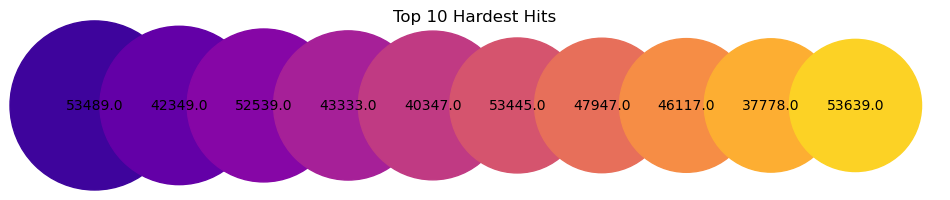

In [ ]:
# Sort the tackles by the 10 largest force
top_tackles_by_force = main_df.nlargest(10, 'force')

# Normalize the force values to determine the size of the circles
top_tackles_by_force['normalized_force'] = (
    top_tackles_by_force['force'] / top_tackles_by_force['force'].max()) * 100
top_tackles_by_force.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 8))
ax = plt.gca()
color_palette = sns.color_palette("plasma", n_colors=10)

for i, (idx, row) in enumerate(top_tackles_by_force.iterrows()):
    circle = plt.Circle((i, 0.5), row['normalized_force'] * 0.01, color=color_palette[i], clip_on=False)
    ax.add_artist(circle)
    plt.text(i, 0.5, str(row['nflId']), ha='center', va='center', color='black')

# Let's set the limits and aspect to fit the circles
ax.set_xlim(-1, len(top_tackles_by_force))
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
plt.title('Top 10 Hardest Hits', pad=30)
plt.show()

This is why we calculated a force profile, if we cross referance this with the other circle plot that dealt with top 10 accelerations, we would notice that not every player that is in that plot is in this plot. This means that acceleration is a big factor in how hard a tackler hits, but their mass, as well as upper body strength, is also just as important.

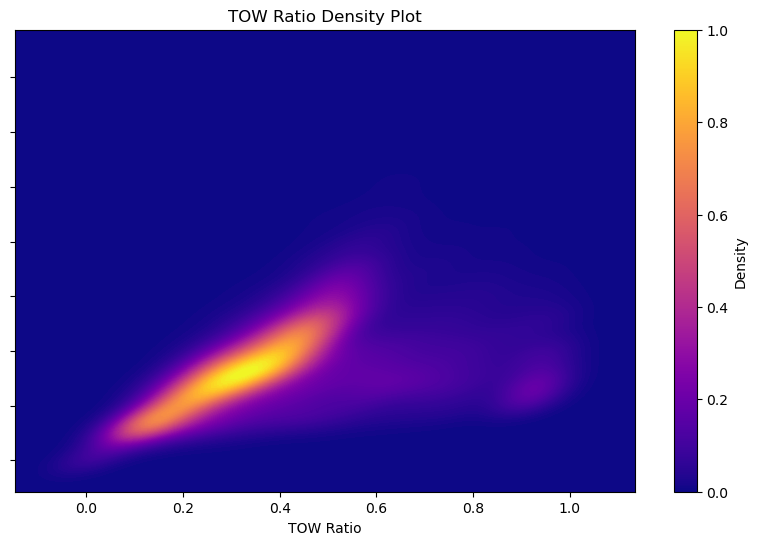

In [ ]:
# Filter the dataframe to include only the rows where a tackle occurred
tackles_with_tow_ratio = main_df[main_df['tackle'] == 1]

plt.figure(figsize=(10, 6))
sns.kdeplot(data=tackles_with_tow_ratio, x='tow_ratio', y='tow', fill=True, thresh=0, levels=100, cmap="plasma")

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), orientation='vertical')
cbar.set_label('Density')

plt.title('TOW Ratio Density Plot')
plt.xlabel('TOW Ratio')
plt.gca().set_yticklabels([])
plt.ylabel('')
plt.show()